# Smart Predictive Maintenance for Industrial Equipment
Students: Marco RIVA, Alessia SARRITZU, Alberto MARTINELLI, Michele PULVIRENTI

## Environment Setup

### Environment Setting

In [1]:
# set to 'True' to ignore saved results and rerun the notebook from scratch. It will take about 5 hours, compared to 5 minutes.
force_rerun = False

### Libraries Installation and imports

Some warning is shown, but it can be safely ignored.

In [2]:
# kernel preparation and import statements
!pip install -q pandas
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q scikit-learn==1.5.2
!pip install -q xgboost
!pip install -q imbalanced-learn
!pip install -q gym
!pip install -q tqdm
!pip install -q torch torchvision torchaudio
!pip install -q dask dask-ml distributed
!pip install -q tpot

# Attempt to set the multiprocessing start method
import multiprocessing
import os
import pickle
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from tpot import TPOTClassifier
from tqdm import tqdm
from xgboost import XGBClassifier

try:
    multiprocessing.set_start_method('forkserver')
except RuntimeError:
    pass

# Step 1: Problem Definition and Dataset Exploration

The **Turbofan Engine Degradation Simulation Data Set** has been chosen as the dataset for this project.

## Dataset Exploration
The dataset is composed of 4 subsets, each one containing the data of a different set of engines. As first step, these subsets will be merged into a single dataset, so to have the complete dataset to work with.
The `engine_id` is renumbered so not to lose the information about the original subset.
Additionally, two columns, `conditions` and `fault_mode`, are added to the dataset; these fields are described in the txt file contained within the dataset folder and originally not included within the values, but just attached as meta information among each different subset.

In [3]:
# definition of some utility functions
def hard_save(obj, file):
    try:
        with open(file, 'wb') as f:
            pickle.dump(obj, f)
    except Exception as e:
        print(f'Error saving file {file}: {e}')
        exit(1)

def hard_load(file):
    try:
        with open(file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f'File {file} not found')
        exit(1)
    except Exception as e:
        print(f'Error loading file {file}: {e}')
        exit(1)

extra_info = [{'conditions': 1, 'fault_mode':1},
              {'conditions': 0, 'fault_mode':1},
              {'conditions': 1, 'fault_mode':0},
              {'conditions': 0, 'fault_mode':0}]

def add_extra_info(df, file_name):
    df['conditions'] = extra_info[subsets.index(int(file_name[-5]))]['conditions']
    df['fault_mode'] = extra_info[subsets.index(int(file_name[-5]))]['fault_mode']
    return file

In [4]:
# importing dataset

dataset_folder_path = './CMAPSSData'
subsets = range(1, 5)

file_paths = [f'train_FD00{i}.txt' for i in subsets]

columns = ['engine_id', 'cycle', 'operational_setting_1', 'operational_setting_2',
           'operational_setting_3', 'operational_setting_4', 'operational_setting_5'] + \
          [f'sensor_{i}' for i in range(1, 22)]

features = [col for col in columns if col.startswith('sensor_') or col.startswith('operational') or col in extra_info[0].keys()]
categorical_features = extra_info[0].keys()

df = None
for file in file_paths:
    new_df = pd.read_csv(os.path.join(dataset_folder_path, file), sep='\s+', header=None, names=columns)
    new_df['engine_id'] = new_df['engine_id'] + 100 * (subsets.index(int(file[-5])) + 1) # renumbering of engine_id
    add_extra_info(new_df, file) # add conditions and fault_mode columns
    df = pd.concat([df, new_df], ignore_index=True)

df

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,operational_setting_4,operational_setting_5,sensor_1,sensor_2,sensor_3,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,conditions,fault_mode
0,101,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,1,1
1,101,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,1,1
2,101,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,1,1
3,101,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,1,1
4,101,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,649,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,0.03,372,2319,100.0,29.11,17.5234,NaN,NaN,0,0
160355,649,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,0.03,396,2388,100.0,39.38,23.7151,NaN,NaN,0,0
160356,649,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,0.03,395,2388,100.0,39.78,23.8270,NaN,NaN,0,0
160357,649,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,0.02,337,2223,100.0,15.26,9.0774,NaN,NaN,0,0


In [5]:
# Generate summary statistics for the dataset
df.describe()

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,operational_setting_4,operational_setting_5,sensor_1,sensor_2,sensor_3,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,conditions,fault_mode
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,0.0,0.0,160359.000000,160359.000000
mean,384.493511,123.331338,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,...,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700,NaN,NaN,0.282809,0.463897
std,140.313745,83.538146,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,...,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067,NaN,NaN,0.450366,0.498696
min,101.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500,NaN,NaN,0.000000,0.000000
25%,296.000000,57.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,...,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300,NaN,NaN,0.000000,0.000000
50%,385.000000,114.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,...,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500,NaN,NaN,0.000000,0.000000
75%,487.000000,173.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,...,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600,NaN,NaN,1.000000,1.000000
max,649.000000,543.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,...,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500,NaN,NaN,1.000000,1.000000


In [6]:
# Check for missing values
df.isnull().sum()

engine_id                     0
cycle                         0
operational_setting_1         0
operational_setting_2         0
operational_setting_3         0
operational_setting_4         0
operational_setting_5         0
sensor_1                      0
sensor_2                      0
sensor_3                      0
sensor_4                      0
sensor_5                      0
sensor_6                      0
sensor_7                      0
sensor_8                      0
sensor_9                      0
sensor_10                     0
sensor_11                     0
sensor_12                     0
sensor_13                     0
sensor_14                     0
sensor_15                     0
sensor_16                     0
sensor_17                     0
sensor_18                     0
sensor_19                     0
sensor_20                160359
sensor_21                160359
conditions                    0
fault_mode                    0
dtype: int64

As it can be seen, columns sensor_20 and sensor_21 are completely empty. This is why they will be dropped from the dataset in the preprocessing section.

### Feature Distribution
The distribution of the features in the dataset can be visualized using histograms from **matplotlib** library. This will help to understand the range of values each feature takes.

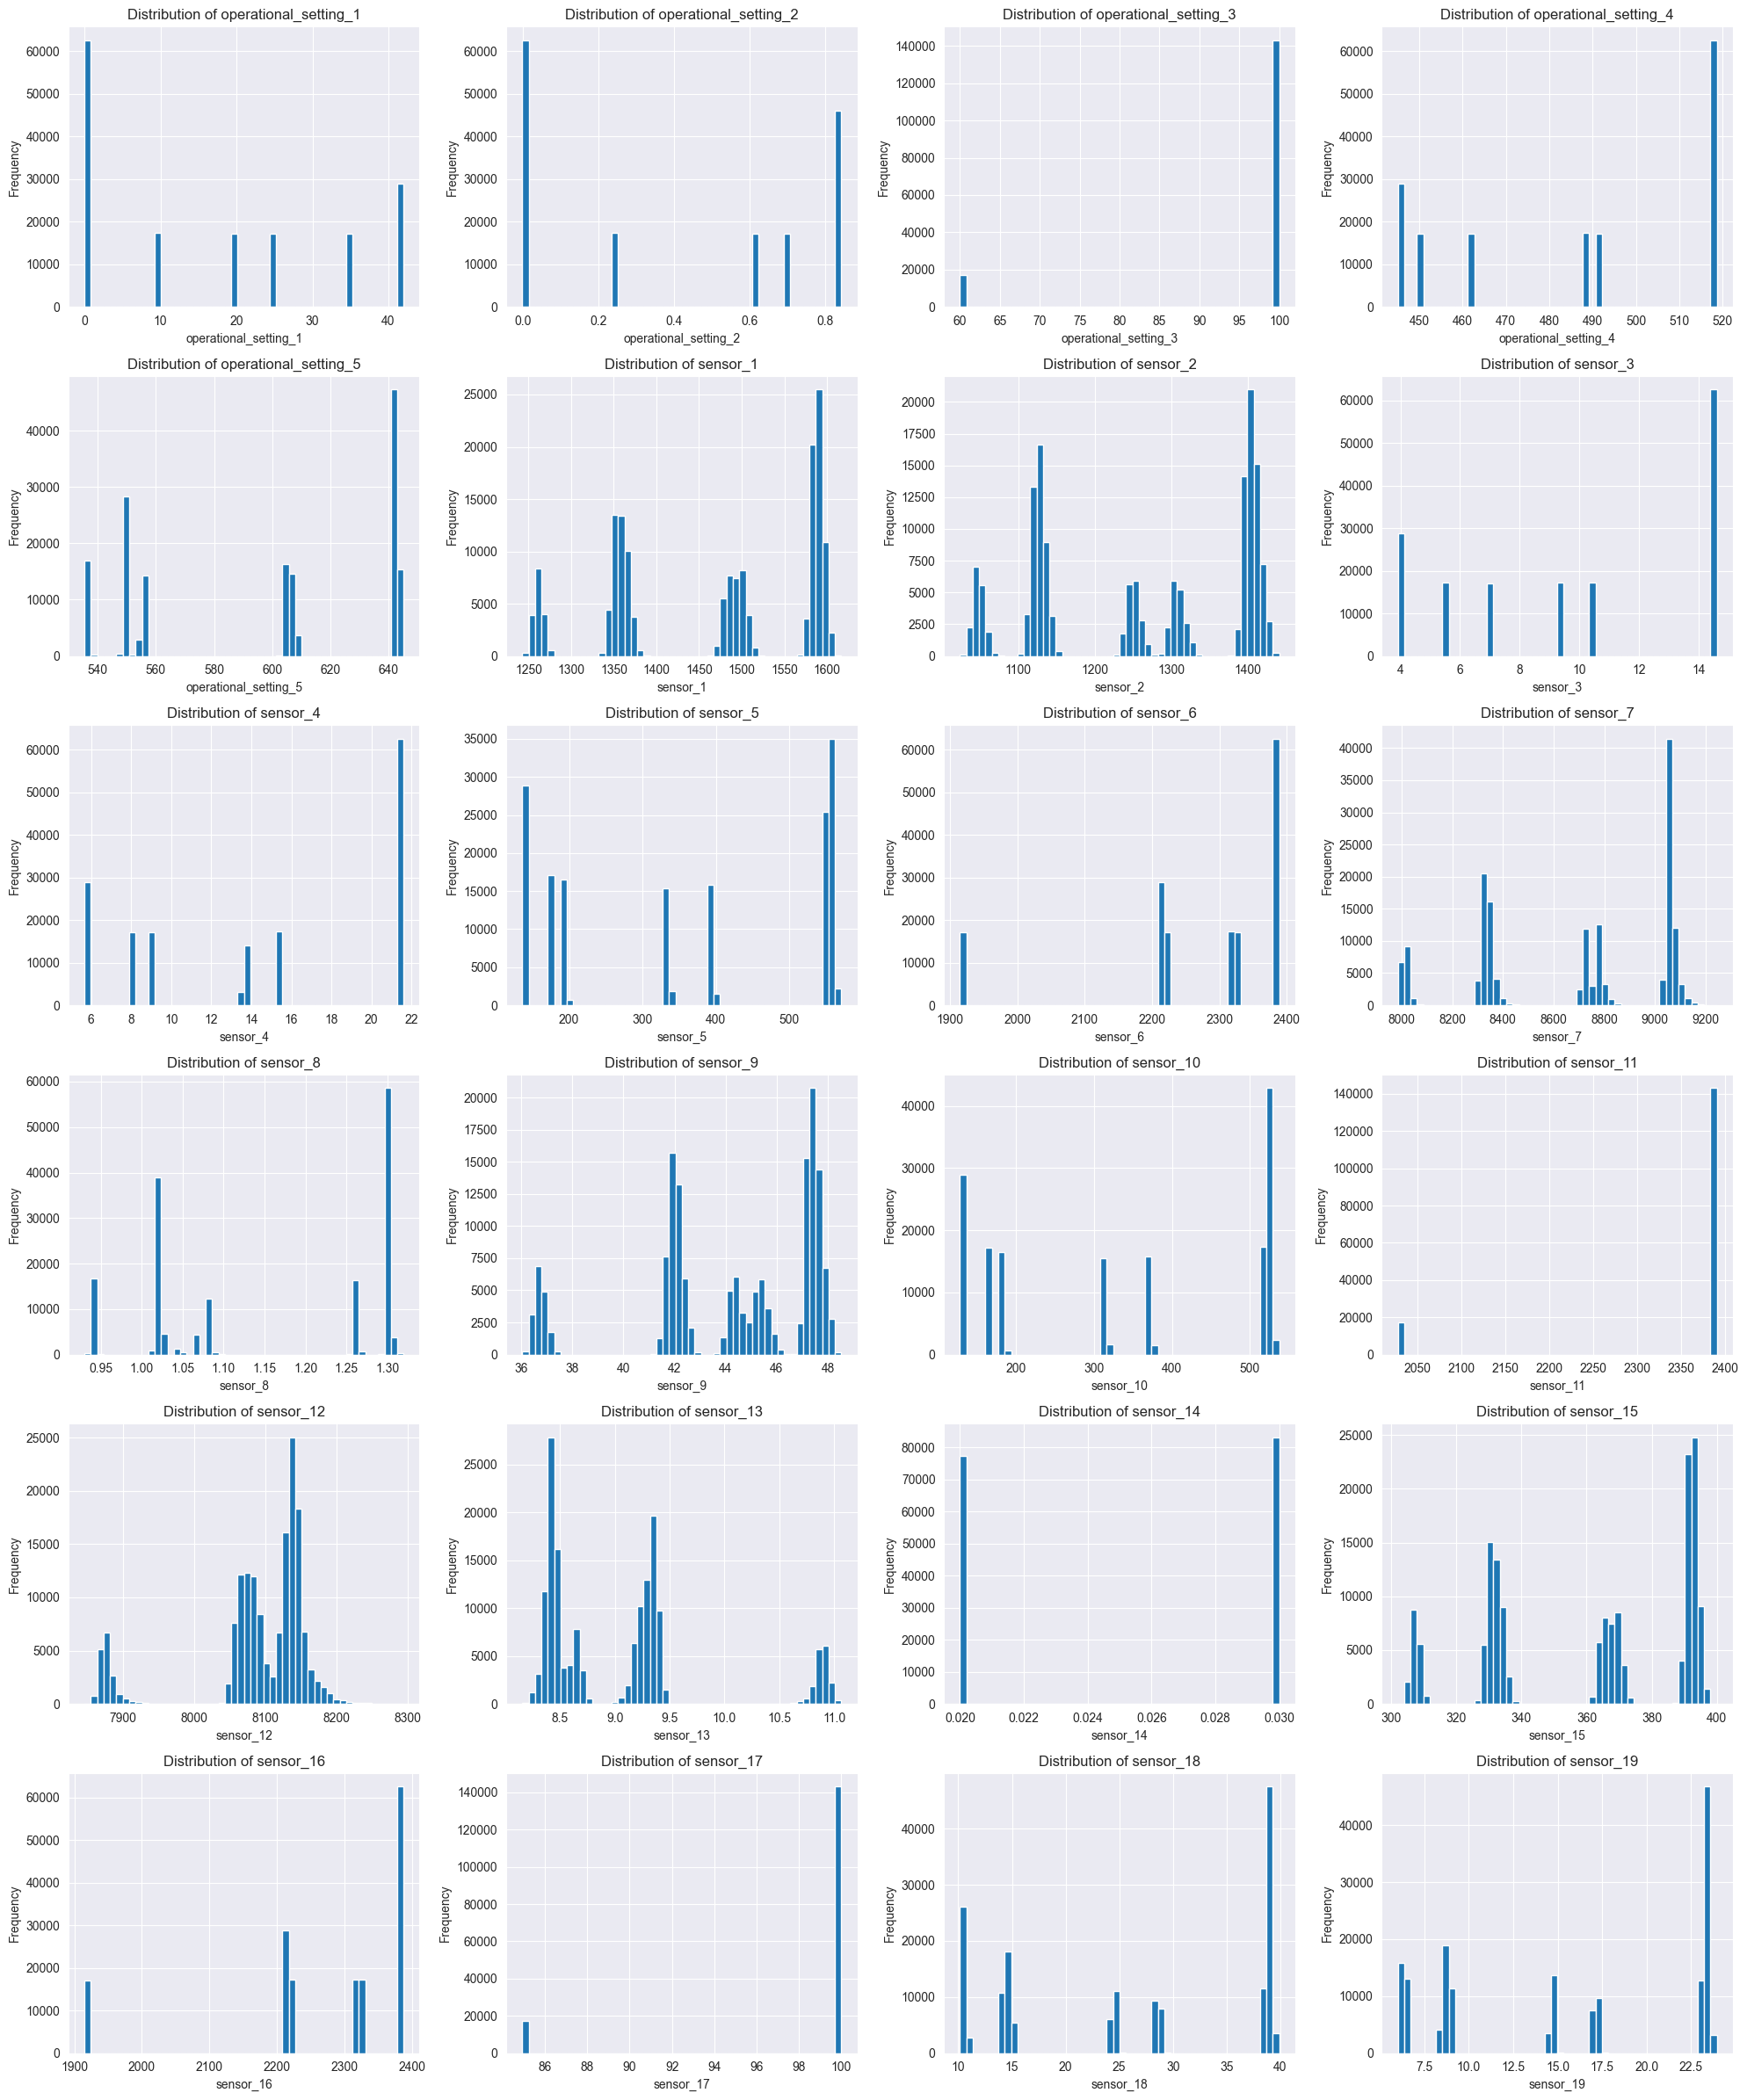

In [7]:
# Plot distributions for all sensors and operational settings
numerical_features = df.drop(columns=['engine_id', 'cycle', 'sensor_20', 'sensor_21', 'conditions', 'fault_mode']).columns

n_cols = 4  # Number of columns in the grid
n_rows = int(np.ceil(len(numerical_features) / n_cols))  # Number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

axs = axs.flatten()

for i, col in enumerate(numerical_features):
    df[col].hist(bins=50, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

for j in range(len(numerical_features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

The provided histograms illustrate the distributions of values for the features in the dataset. Some observations can be made:

- **categorical-like operational settings**:
    Features like `operational_setting_1`, `operational_setting_2`, and `operational_setting_5` exhibit discrete values clustered into distinct groups.
    While this may suggest that these operational settings could potentially be treated as categorical variables, this would make them lose their ordinal nature.

- **sensors' value distributions**:
    Some sensors have very narrow distributions, with most values concentrated in a small range or on a single mode.
    On the other hand, other sensors exhibit multimodal distributions, suggesting they capture distinct operating states of the engines.

- **operational settings**:
    Most of the operational settings have highly restricted ranges, with most values concentrated in a single cluster.
    This could mean these settings remain constant or change rarely, possibly having limited relevance for failure prediction.

The insights from these distributions can be useful for the preprocessing and feature engineering steps, to improve the predictive performance of the models.

### Correlation Matrix
Using the **seaborn** library, the correlation matrix of the features in the dataset can be visualized. This will help to understand the relationships between the different sensors and operational settings.

Constants columns are also identified and removed from the dataset.

Ignoring constant columns: ['sensor_20', 'sensor_21']


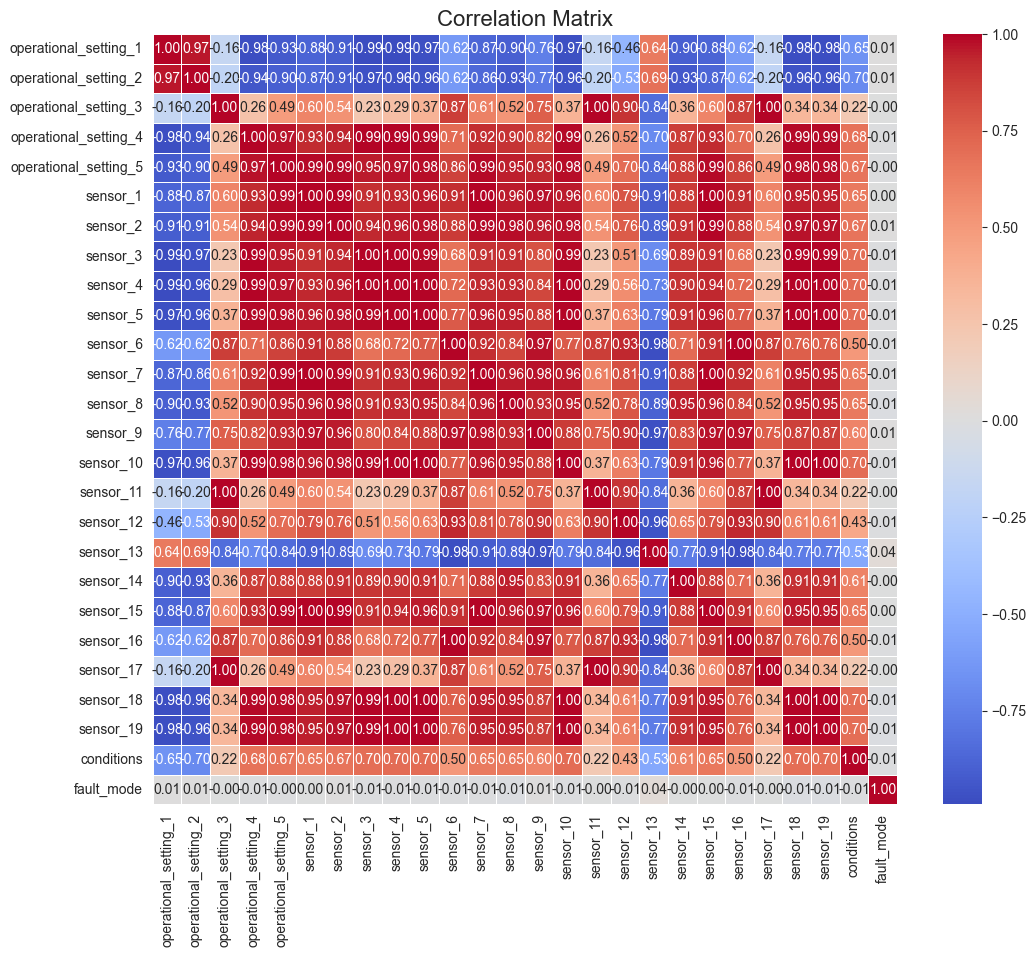

In [8]:
# constant columns handling
constant_columns = df.columns[df.nunique() <= 1]
print(f"Ignoring constant columns: {constant_columns.tolist()}")
per_correlation_matrix_data = df.drop(columns=constant_columns)

# compute correlation matrix
correlation_matrix = per_correlation_matrix_data.drop(columns=['engine_id', 'cycle']).corr()

# visualization
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


The correlation matrix provides interesting insights into the relationships between the various features of the dataset:

- **prevalence of strong positive correlations**:
    Many sensor readings (e.g., `sensor_2` to `sensor_19`) and operational settings (`operational_setting_1`, `operational_setting_2`) exhibit near-perfect correlations (`>0.9`) with each other.
    This suggests some redundancy in the dataset or sensors measuring similar aspects of the engines, where certain features may not add additional information for prediction.
    These correlations indicate that dimensionality reduction techniques or removal could help improve computational efficiency and reduce overfitting.

- **fault mode Correlation**:
  Very low (or none) correlation is shown for the `fault_mode` feature: this suggests that this feature may not be very informative for predicting faults.
  Such low-correlated features might be candidates for removal, depending on their interaction effects with other features or machine learning model importance rankings.

### Class imbalance visualization

The dataset is highly imbalanced, with the majority of instances belonging to the "Normal" class (meaning no failure) and only a small fraction of instances belonging to the "failure" class.

In order to better define a failed engine, a threshold of 20 cycles before the end of life (RUL = 0) will be used. An engine having a RUL less than or equal to this threshold will be labeled as `faulty`.

This class imbalance will be later addressed in the preprocessing section.

In [9]:
target_reg = 'RUL'
target_cat = 'failure_label'

def label_failures(df, failure_threshold=20):
    df[target_cat] = (df[target_reg] <= failure_threshold).astype(int)
    return df

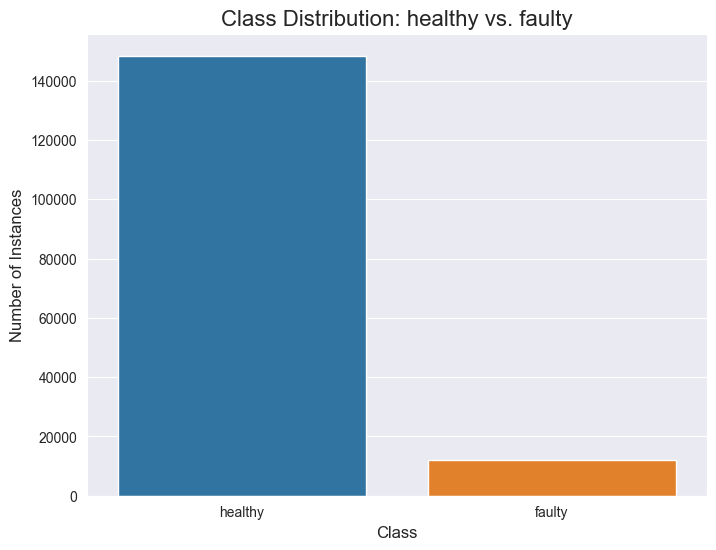

In [10]:
failure_threshold = 20
class_labels = ['healthy', 'faulty']

# Calculate RUL for each engine in the training dataset
df['RUL'] = df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

df = label_failures(df, failure_threshold)

class_counts = df[target_cat].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, legend=False)
plt.title("Class Distribution: healthy vs. faulty", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Instances", fontsize=12)
plt.xticks([0, 1], labels=class_labels, fontsize=10)
plt.show()

# Step 2: Preprocessing and Feature Engineering
## Preprocessing
### Merging sets

In this section, the `test_XXXX` files are also included in the dataset, with the RUL and the failure label added (using the corresponding `RUL_XXXX` files).

In [11]:
df_cleaned = df.copy()

for i in subsets:
    test_path = f'test_FD00{i}.txt'
    rul_path = f'RUL_FD00{i}.txt'

    new_test = pd.read_csv(os.path.join(dataset_folder_path, test_path), sep='\s+', header=None, names=columns)
    new_rul = pd.read_csv(os.path.join(dataset_folder_path, rul_path), sep='\s+', header=None, names=['RUL'])

    add_extra_info(new_test, test_path)

    new_row = pd.DataFrame({'RUL': [0]})
    new_rul = pd.concat([new_row, new_rul], ignore_index=True)
    new_rul.rename(columns={"RUL": "RUL_rul_file"}, inplace=True)

    new_test['max_cycle'] = new_test.groupby('engine_id')['cycle'].transform('max')

    # Merge the RUL data with the test set
    new_test = new_test.merge(new_rul, left_on='engine_id', right_index=True, how='left')

    # Calculate the RUL for each cycle in the test set
    new_test['RUL'] = new_test['RUL_rul_file'] + (new_test['max_cycle'] - new_test['cycle'])

    new_test['engine_id'] = new_test['engine_id'] + 1000 * i # renumbering of engine_id
    
    # Drop intermediate columns
    new_test = new_test.drop(columns=['max_cycle', 'RUL_rul_file'])
    
    # Label failures, as done in the original part of the dataset
    new_test = label_failures(new_test, failure_threshold)
    
    # Merge test_data with the df
    df_cleaned = pd.concat([df_cleaned, new_test], ignore_index=True)

df_cleaned

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,operational_setting_4,operational_setting_5,sensor_1,sensor_2,sensor_3,...,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,conditions,fault_mode,RUL,failure_label
0,101,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388,100.0,39.06,23.4190,NaN,NaN,1,1,191,0
1,101,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388,100.0,39.00,23.4236,NaN,NaN,1,1,190,0
2,101,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388,100.0,38.95,23.3442,NaN,NaN,1,1,189,0
3,101,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388,100.0,38.88,23.3739,NaN,NaN,1,1,188,0
4,101,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388,100.0,38.90,23.4044,NaN,NaN,1,1,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265251,4248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,2212,100.0,10.53,6.2620,NaN,NaN,0,0,30,0
265252,4248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,2324,100.0,24.33,14.6486,NaN,NaN,0,0,29,0
265253,4248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,2223,100.0,14.69,8.8389,NaN,NaN,0,0,28,0
265254,4248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,2324,100.0,24.44,14.6887,NaN,NaN,0,0,27,0


### Missing Values
As noticed before, the columns `sensor_20` and `sensor_21` are completely empty: they are now dropped from the dataset.

In [12]:
columns_to_drop = ['sensor_20', 'sensor_21']

df_cleaned = df_cleaned.drop(columns=columns_to_drop)
features_in_use = [feature for feature in features if feature not in columns_to_drop]

### Feature Scaling

The features in the dataset are scaled using Min-Max scaling to ensure that all features have the same scale.

In [13]:
df_preprocessed = df_cleaned.copy()

scaler = MinMaxScaler()
features_to_scale = [feature for feature in features_in_use if feature not in categorical_features]
df_preprocessed_scaled = scaler.fit_transform(df_preprocessed[features_to_scale])

df_preprocessed[features_to_scale] = df_preprocessed_scaled
df_preprocessed

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,operational_setting_4,operational_setting_5,sensor_1,sensor_2,sensor_3,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,conditions,fault_mode,RUL,failure_label
0,101,1,0.000190,0.000237,1.0,1.000000,0.970009,0.927627,0.902111,1.000000,...,1.0,0.918367,1.000000,1.0,0.972082,0.970373,1,1,191,0
1,101,2,0.000252,0.000356,1.0,1.000000,0.973017,0.933266,0.908192,1.000000,...,1.0,0.918367,1.000000,1.0,0.970064,0.970630,1,1,190,0
2,101,3,0.000105,0.001068,1.0,1.000000,0.974840,0.923079,0.910730,1.000000,...,1.0,0.897959,1.000000,1.0,0.968382,0.966204,1,1,189,0
3,101,4,0.000224,0.000712,1.0,1.000000,0.974840,0.909248,0.905152,1.000000,...,1.0,0.918367,1.000000,1.0,0.966028,0.967860,1,1,188,0
4,101,5,0.000162,0.000475,1.0,1.000000,0.975023,0.909408,0.915565,1.000000,...,1.0,0.928571,1.000000,1.0,0.966700,0.969560,1,1,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265251,4248,277,0.999788,0.997745,1.0,0.000000,0.135734,0.328377,0.252322,0.000000,...,0.0,0.295918,0.627907,1.0,0.012445,0.014019,0,0,30,0
265252,4248,278,0.476270,0.832067,1.0,0.626985,0.661714,0.675080,0.567629,0.507937,...,0.0,0.653061,0.864693,1.0,0.476623,0.481499,0,0,29,0
265253,4248,279,0.833181,0.999169,1.0,0.060269,0.186964,0.345001,0.256631,0.146592,...,0.0,0.346939,0.651163,1.0,0.152371,0.157659,0,0,28,0
265254,4248,280,0.476273,0.831474,1.0,0.626985,0.663446,0.660079,0.556545,0.507937,...,1.0,0.653061,0.864693,1.0,0.480323,0.483735,0,0,27,0


## Feature Engineering

In this section, additional features are created from the existing ones in the dataset.

As first step, the means of the features are displayed in order to select the most relevant ones, splitting the between values among the two classes (`healthy` and `faulty`).

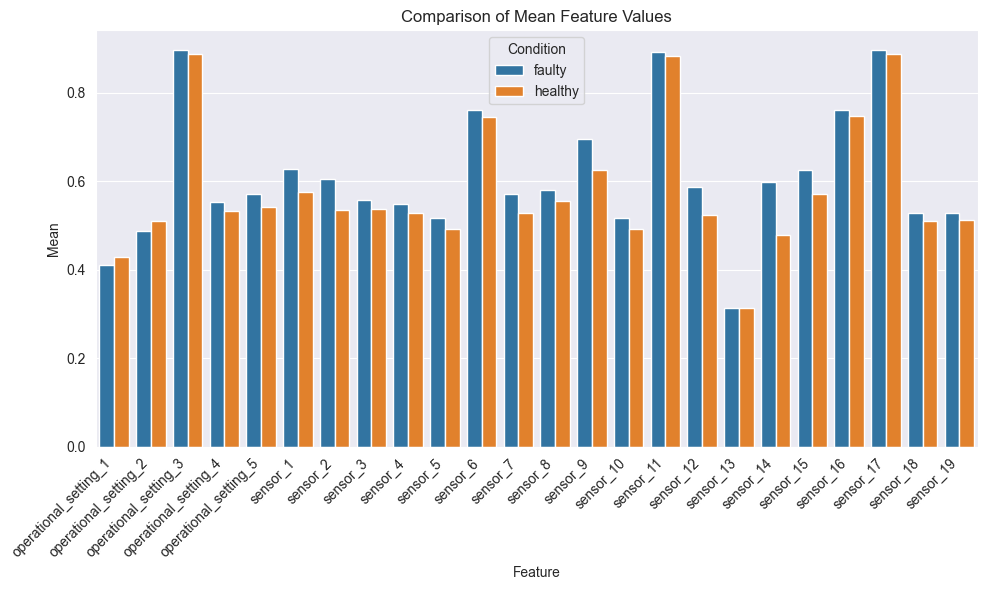

In [14]:
# Split data based on RUL
faulty = df_preprocessed[df_preprocessed['RUL'] <= failure_threshold]
healthy = df_preprocessed[df_preprocessed['RUL'] >= 200]

features_to_plot = features_to_scale

# Calculate mean values for each group
means_faulty = faulty[features_to_plot].mean()
means_healthy = healthy[features_to_plot].mean()

# Prepare data for seaborn
comparison_df = pd.DataFrame({
    'Feature': features_to_plot,
    'faulty': means_faulty,
    'healthy': means_healthy
}).melt(id_vars='Feature', var_name='Condition', value_name='Mean')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Feature', y='Mean', hue='Condition')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of Mean Feature Values')
plt.tight_layout()
plt.show()

It can be noticed that some features have a significant mean value difference between the two classes, suggesting that they could be useful for distinguishing between healthy and faulty engines. These features will be used for creating rolling averages in the next step.

In [15]:
rolling_window = 20

df_preprocessed_rolling_avg = df_preprocessed.copy()

# Apply rolling averages
rolling_features = ['sensor_4', 'sensor_11', 'sensor_14']
for feat in rolling_features:
    df_preprocessed_rolling_avg[f'{feat}_rolling_avg'] = df_preprocessed[feat].rolling(window=rolling_window, min_periods=1).mean()

features_in_use += [f'{feat}_rolling_avg' for feat in rolling_features]

df_preprocessed = df_preprocessed_rolling_avg

df_preprocessed_rolling_avg

,engine_id,cycle,operational_setting_1,operational_setting_2,operational_setting_3,operational_setting_4,operational_setting_5,sensor_1,sensor_2,sensor_3,...,sensor_17,sensor_18,sensor_19,conditions,fault_mode,RUL,failure_label,sensor_4_rolling_avg,sensor_11_rolling_avg,sensor_14_rolling_avg
0,101,1,0.000190,0.000237,1.0,1.000000,0.970009,0.927627,0.902111,1.000000,...,1.0,0.972082,0.970373,1,1,191,0,1.000000,0.993194,1.00
1,101,2,0.000252,0.000356,1.0,1.000000,0.973017,0.933266,0.908192,1.000000,...,1.0,0.970064,0.970630,1,1,190,0,1.000000,0.993263,1.00
2,101,3,0.000105,0.001068,1.0,1.000000,0.974840,0.923079,0.910730,1.000000,...,1.0,0.968382,0.966204,1,1,189,0,1.000000,0.993249,1.00
3,101,4,0.000224,0.000712,1.0,1.000000,0.974840,0.909248,0.905152,1.000000,...,1.0,0.966028,0.967860,1,1,188,0,1.000000,0.993277,1.00
4,101,5,0.000162,0.000475,1.0,1.000000,0.975023,0.909408,0.915565,1.000000,...,1.0,0.966700,0.969560,1,1,187,0,1.000000,0.993271,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265251,4248,277,0.999788,0.997745,1.0,0.000000,0.135734,0.328377,0.252322,0.000000,...,1.0,0.012445,0.014019,0,0,30,0,0.429279,0.944453,0.45
265252,4248,278,0.476270,0.832067,1.0,0.626985,0.661714,0.675080,0.567629,0.507937,...,1.0,0.476623,0.481499,0,0,29,0,0.423542,0.944473,0.40
265253,4248,279,0.833181,0.999169,1.0,0.060269,0.186964,0.345001,0.256631,0.146592,...,1.0,0.152371,0.157659,0,0,28,0,0.400031,0.944535,0.35
265254,4248,280,0.476273,0.831474,1.0,0.626985,0.663446,0.660079,0.556545,0.507937,...,1.0,0.480323,0.483735,0,0,27,0,0.424922,0.944541,0.40


### Finalizing the Dataset

The dataset is split into features and labels, where the features are the sensor readings and operational settings, and the labels is just the failure label.

The dataset is also stored in a file for future use.

In [16]:
X = df_preprocessed[features_in_use]
y = df_preprocessed[target_cat]

hard_save(df_preprocessed, 'df_preprocessed.pkl')

# Step 3: Applying Ensemble Learning (Bagging and Boosting)

## Train-Test Split

The dataset is split into training and testing sets using an 80-20 split, with stratification to maintain the class balance in both sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Models

In this section, three ensemble learning models are trained and evaluated on the dataset:
- **Random Forest (Bagging)**
- **Gradient Boosting (Boosting)**
- **XGBoost (Boosting)**

Their performance is evaluated using standard metrics.

In [18]:
# definition of some utility functions

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    report = metrics.classification_report(y_test, y_pred, target_names=class_labels)
    roc_auc = metrics.roc_auc_score(y_test, y_prob)
    confusion_m = metrics.confusion_matrix(y_test, y_pred)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    return report, roc_auc, confusion_m, accuracy, precision, recall, f1, fpr, tpr

def plot_roc_curve(y_test, y_pred_prob, label):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{label}: ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_results(classification_text, fpr, tpr, roc_auc, confusion_m, label):
    """
    Plots the classification report, ROC curve, and confusion matrix heatmap on the same row.
    """
    
    # Create a 1x3 layout for the plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Add classification report as text in the first subplot
    axes[0].axis('off')
    axes[0].text(0.5, 0.5, classification_text, fontsize=12, va='center', ha='center', wrap=False, family='monospace')
    axes[0].set_title('Classification Report')
    
    # Plot the ROC curve in the second subplot
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc="lower right")
    
    # Plot the confusion matrix heatmap in the third subplot
    sns.heatmap(confusion_m, annot=True, fmt='g', cmap='Blues', ax=axes[2])
    axes[2].set_title('Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    axes[2].xaxis.set_ticklabels(class_labels)
    axes[2].yaxis.set_ticklabels(class_labels)

    fig.suptitle(label, fontsize=16)
    plt.tight_layout()
    
    plt.show()
    
def find_best(storage, metric='accuracy', models_filter=None):
    """
    Find the best model in the storage based on the given metric.
    :param storage: the file path or object containing the model results
    :param metric: the metric to use for comparison. Default is 'accuracy'
    :param models_filter: 
    :return: 
    """
    
    storage = hard_load(storage) if isinstance(storage, str) else storage
    
        
    if models_filter is not None:
        storage = {k: v for k, v in storage.items() if models_filter in k}
    
    if len(storage) == 0:
        print('No models in the storage' if models_filter is None else f'No models matching filter "{models_filter}"')
        exit(1)
        
    if metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        best_model = max(storage, key=lambda x: storage[x][metric])
    else:
        print('Unsupported metric')
        exit(1)
        
    return best_model

def run_model(model, X_train, y_train, X_test, y_test, save_to=None, model_name=None, override=False):
    """
    Evaluate a model and print and save the results.
    :param model: the model (object) to evaluate
    :param save_to: the file path or object to save the results to 
    :param model_name: the string name of the model, used for saving and printing. Required if save_to is not None, otherwise defaults to 'Model'
    :param override: whether to override the model if it already exists in the storage. Default is False
    :return: the (updated) save_to variable, if provided
    """
    if model is None or X_train is None or y_train is None or X_test is None or y_test is None:
        print('model, X_train, y_train, X_test, and y_test are required')
        exit(1)
    
    storage = None
    if save_to is None:
        model = train_model(model, X_train, y_train)
        report, roc_auc, confusion_m, accuracy, precision, recall, f1, fpr, tpr = evaluate_model(model, X_test, y_test)
    else:
        if model_name is None:
            print('Provide a name for the model')
            exit(1)
            
        storage = hard_load(save_to) if isinstance(save_to, str) else save_to
        storage = {} if storage is None else storage
        
        if model_name not in storage.keys() or override:
            model = train_model(model, X_train, y_train)
            report, roc_auc, confusion_m, accuracy, precision, recall, f1, fpr, tpr = evaluate_model(model, X_test, y_test)
            storage[model_name] = {'model': model, 'report': report, 'roc_auc': roc_auc, 'confusion_matrix': confusion_m, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'fpr': fpr, 'tpr': tpr}
            hard_save(storage, save_to)
        else:
            report = storage[model_name]['report']
            roc_auc = storage[model_name]['roc_auc']
            confusion_m = storage[model_name]['confusion_matrix']
            fpr = storage[model_name]['fpr']
            tpr = storage[model_name]['tpr']
            
    plot_results(report, fpr, tpr, roc_auc, confusion_m, model_name if model_name is not None else 'Model')
    return storage

def plot_comparison(stored_metrics, models_names=None, metrics_to_plot=None):
    """
    Plot a bar chart comparing the metric of different models.
    :param stored_metrics: the object containing the model metrics
    :param models_names: the list of model names to plot. Default is None (all models will be plotted)
    :param metrics_to_plot: the list of metrics to plot. Default is ['accuracy', 'precision', 'recall', 'f1']
    """
    
    if metrics_to_plot is None:
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    rows = []
    filtered_results = stored_metrics if models_names is None else {k: v for k, v in stored_metrics.items() if k in models_names}
    
    for model_name, model_metrics in filtered_results.items():
        for metric_name, value in model_metrics.items():
            if metric_name in metrics_to_plot:
                rows.append({'Model': model_name, 'Metric': metric_name, 'Score': value})
    
    df_plot = pd.DataFrame(rows)
    
    # Set Seaborn style
    sns.set(style="whitegrid")
    
    # Create a grouped barplot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_plot, x="Metric", y="Score", hue="Model", palette="Set2")
    
    # Add titles and labels
    ax.set_title("Models Comparison", fontsize=16)
    ax.set_xlabel("Metric", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    
    # Customize legend
    ax.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

### Random Forest (bagging)

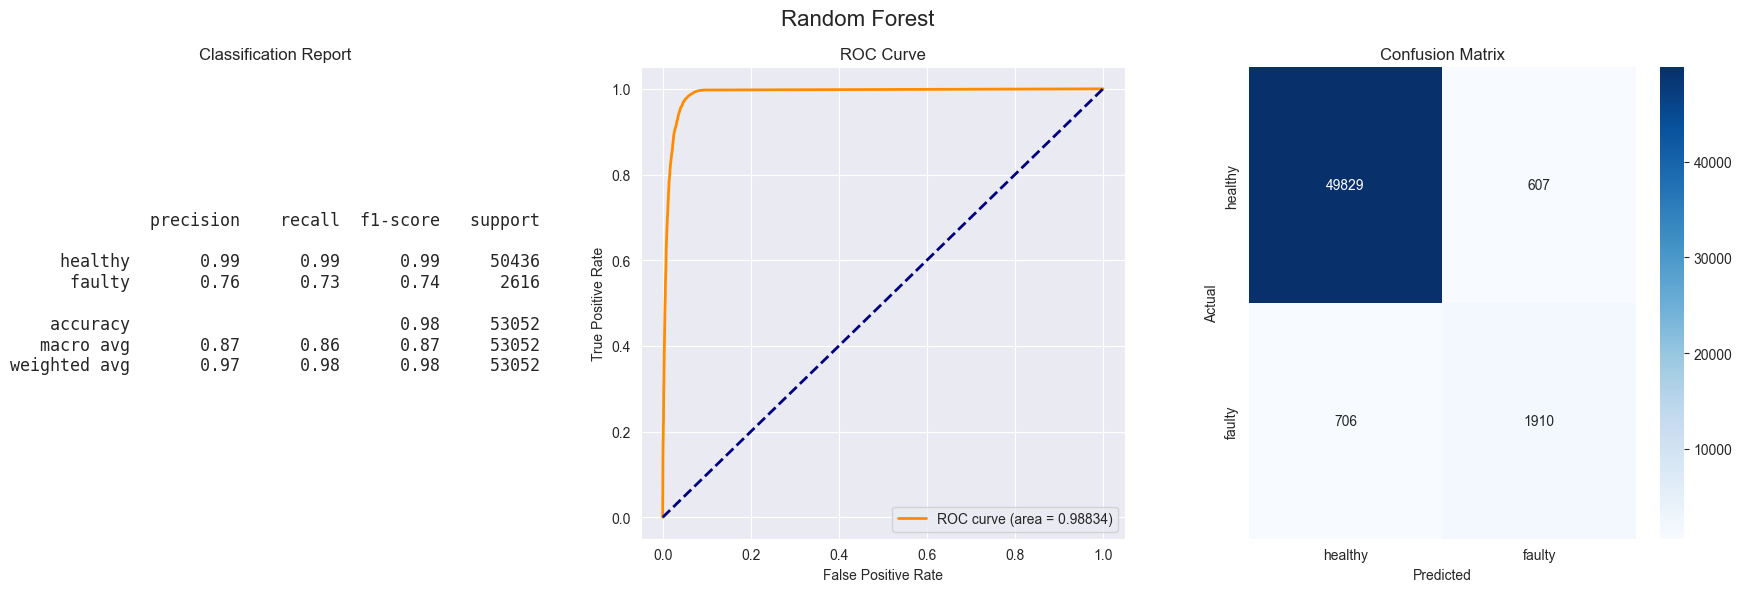

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
_ = run_model(rf_model, X_train, y_train, X_test, y_test, 'model_results.pkl', 'Random Forest', override=force_rerun)

### Gradient Boosting (Boosting)

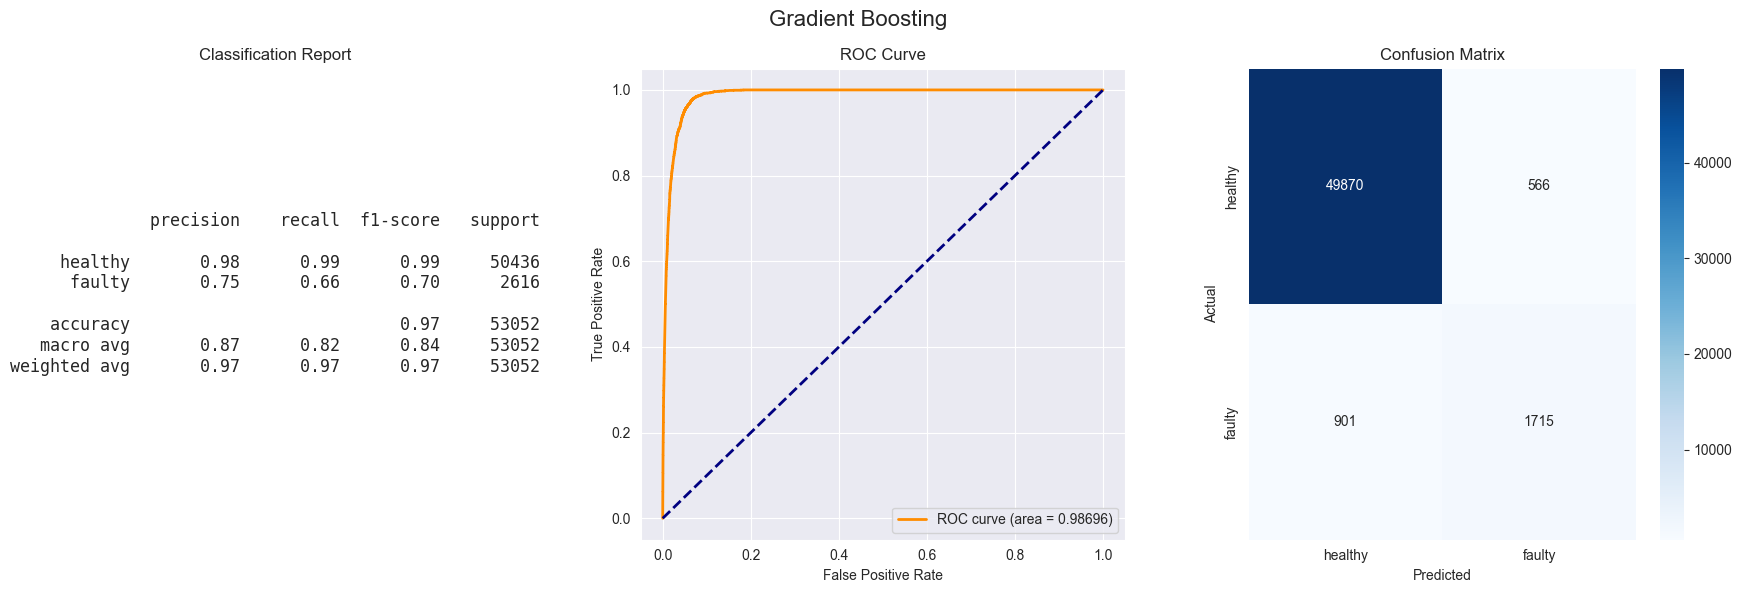

In [20]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
_ = run_model(gb_model, X_train, y_train, X_test, y_test, 'model_results.pkl', 'Gradient Boosting', override=force_rerun)

### XGBoost (Boosting)

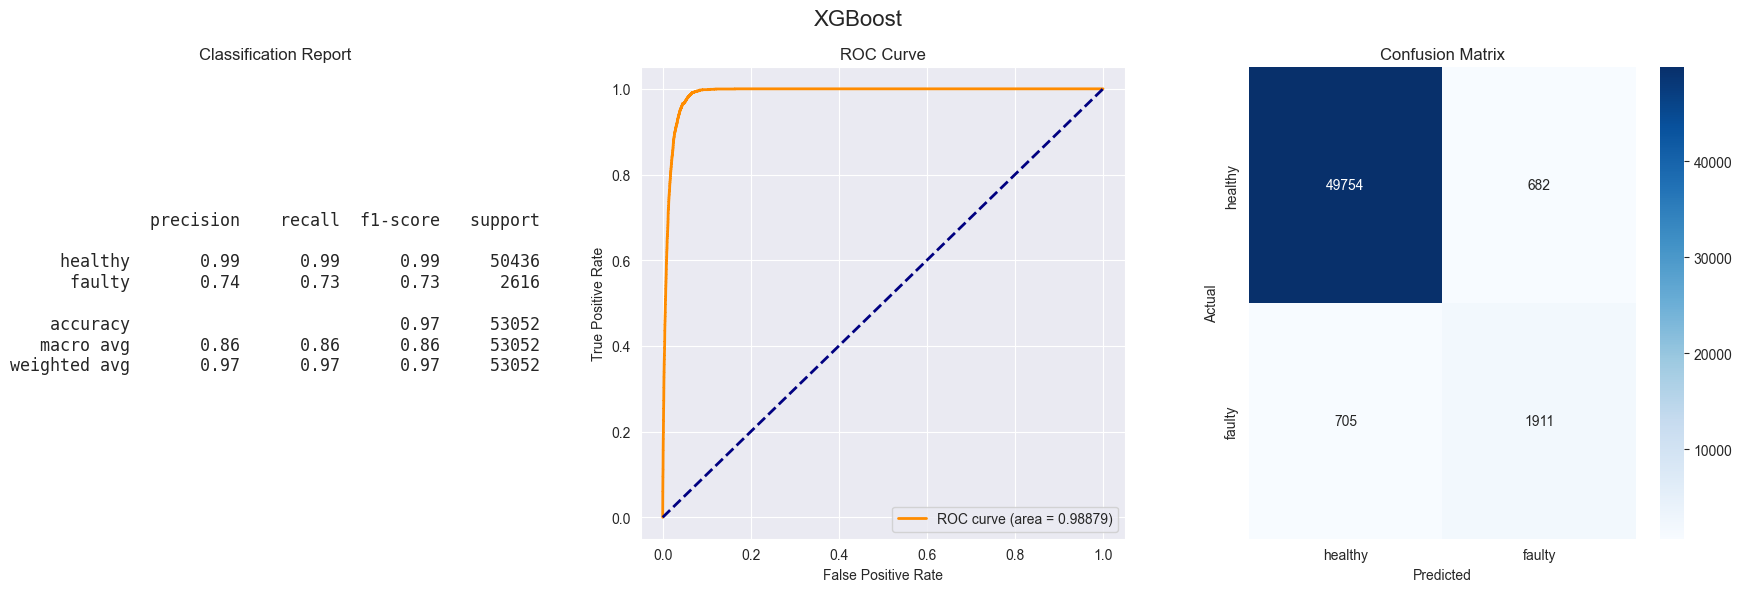

In [21]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42, tree_method='gpu_hist')
_ = run_model(xgb_model, X_train, y_train, X_test, y_test, 'model_results.pkl', 'XGBoost', override=force_rerun)

## Comparison and considerations

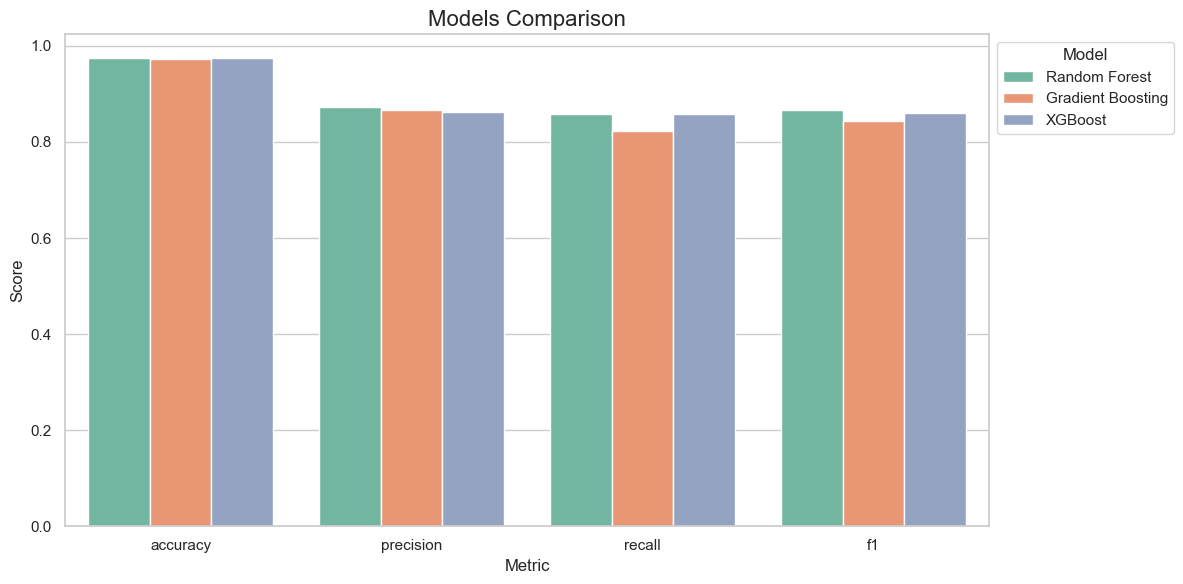

In [22]:
plot_comparison(hard_load('model_results.pkl'), ['Random Forest', 'Gradient Boosting', 'XGBoost'])

It can be seen that the three models perform similarly, with the Random Forest model slightly outperforming the other two models in terms of accuracy and F1 score.

It can be noted that the general performance of the models is already quite good, even without having handled the class imbalance in the dataset.

# Step 4: Handling Imbalanced Data

In this section, different techniques are tested to handle the class imbalance in the dataset. The following methods are used:
- **Oversampling**: Synthetic Minority
- **Undersampling**: Random Undersampling
- **SMOTEENN**: Combining SMOTE and Edited Nearest Neighbors
- **Cost-sensitive Learning**: Assigning class weights based on the class distribution

After each method is applied, all the models are re-trained and re-evaluated. The results are then compared to the original models.

## Oversampling

In [23]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution before SMOTE:\n", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())

Class distribution before SMOTE:
 failure_label
0    201739
1     10465
Name: count, dtype: int64
Class distribution after SMOTE:
 failure_label
0    201739
1    201739
Name: count, dtype: int64


### Random Forest

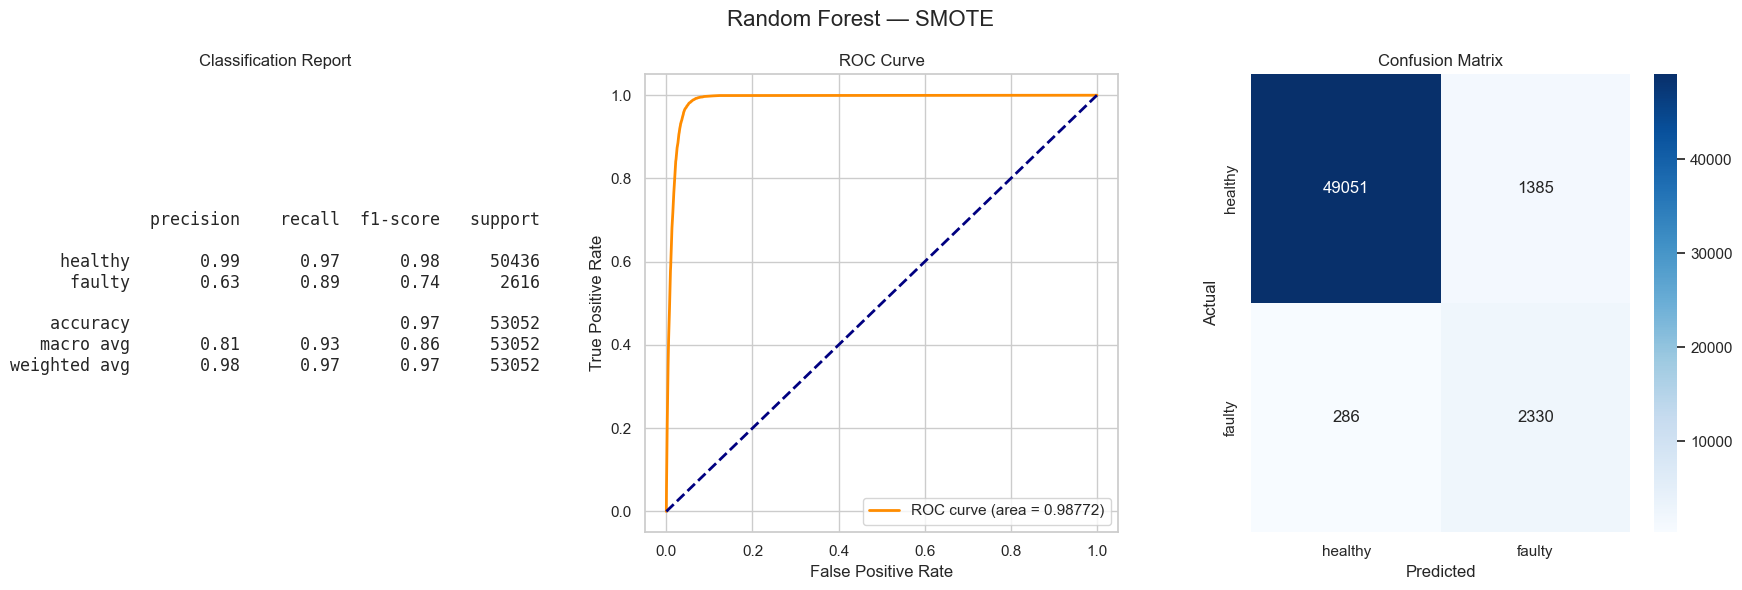

In [24]:
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
_ = run_model(rf_smote, X_train_smote, y_train_smote, X_test, y_test, 'model_results.pkl', 'Random Forest — SMOTE', override=force_rerun)

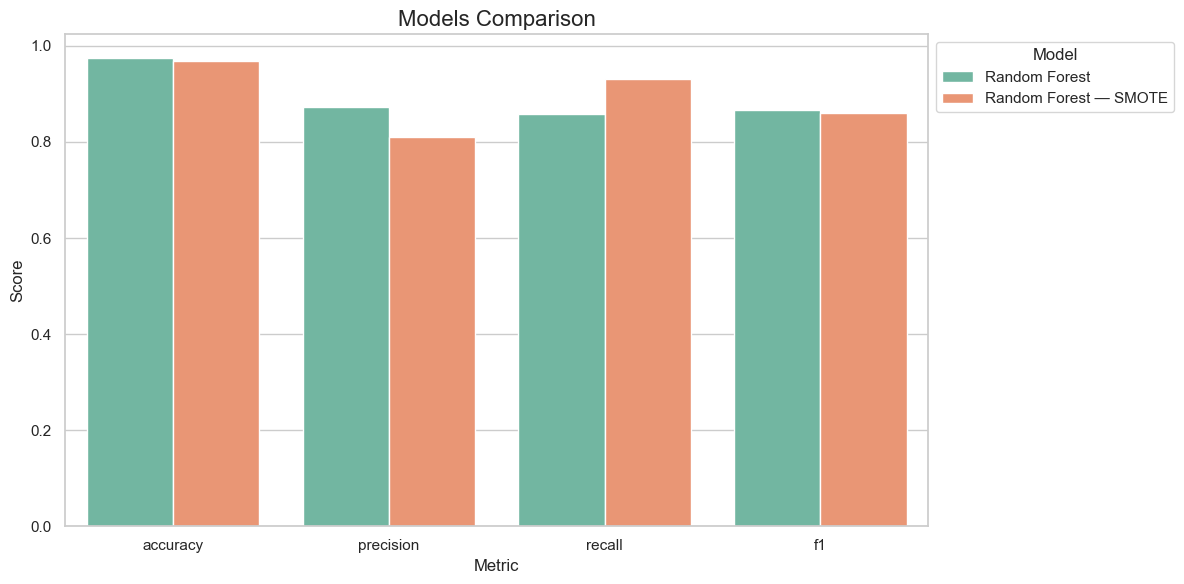

In [25]:
plot_comparison(hard_load('model_results.pkl'), ['Random Forest', 'Random Forest — SMOTE'])

### Gradient Boosting

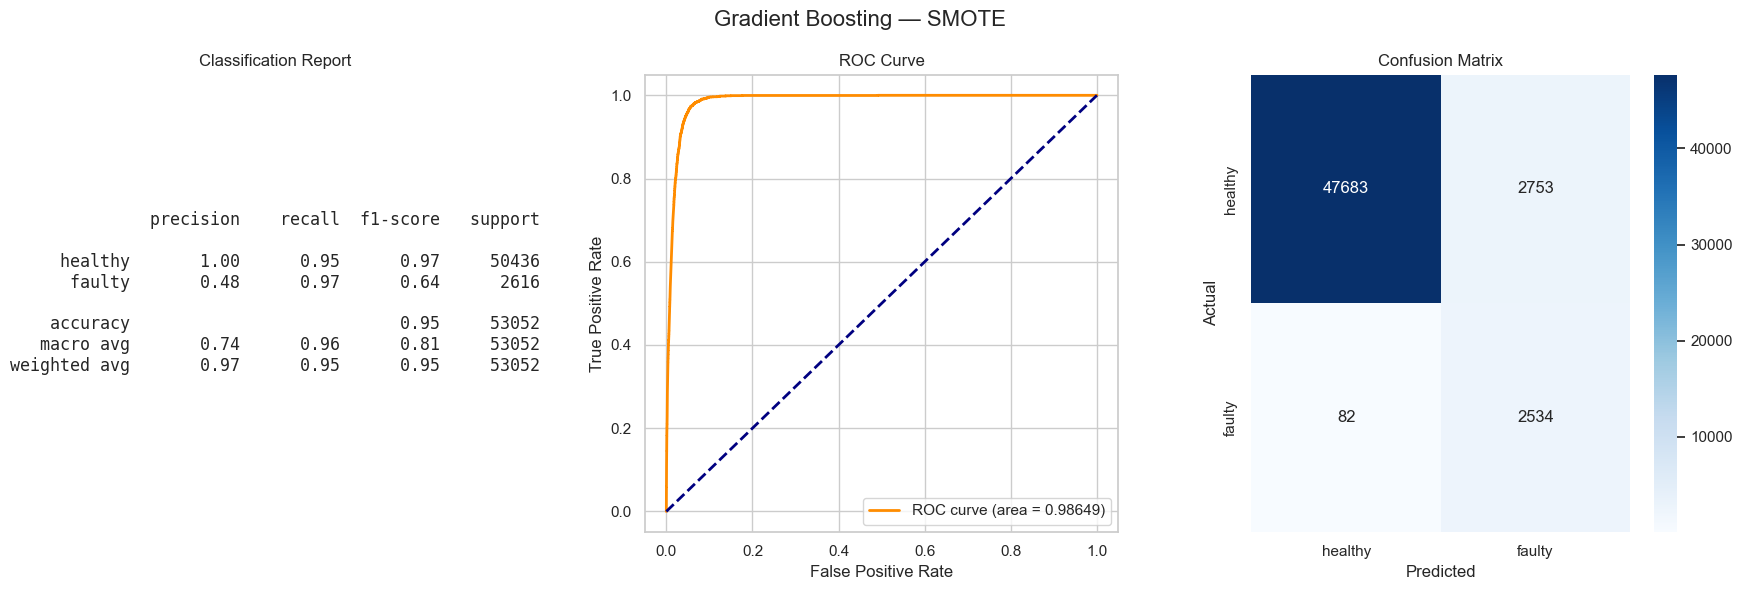

In [26]:
gb_smote = GradientBoostingClassifier(n_estimators=100, random_state=42)
_ = run_model(gb_smote, X_train_smote, y_train_smote, X_test, y_test, 'model_results.pkl', 'Gradient Boosting — SMOTE', override=force_rerun)

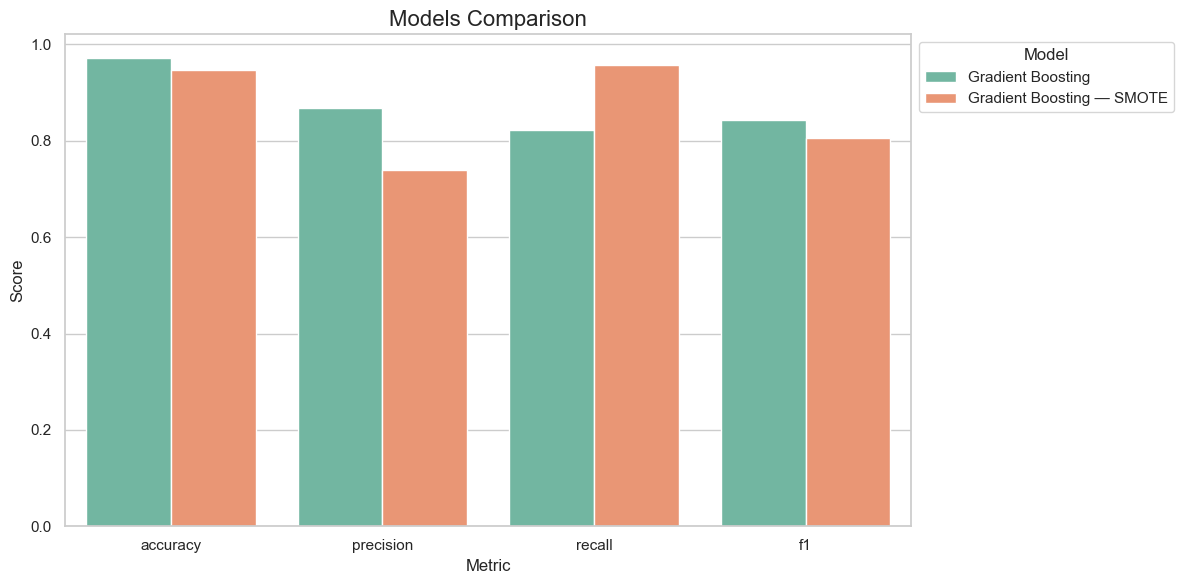

In [27]:
plot_comparison(hard_load('model_results.pkl'), ['Gradient Boosting', 'Gradient Boosting — SMOTE'])

### XGBoost

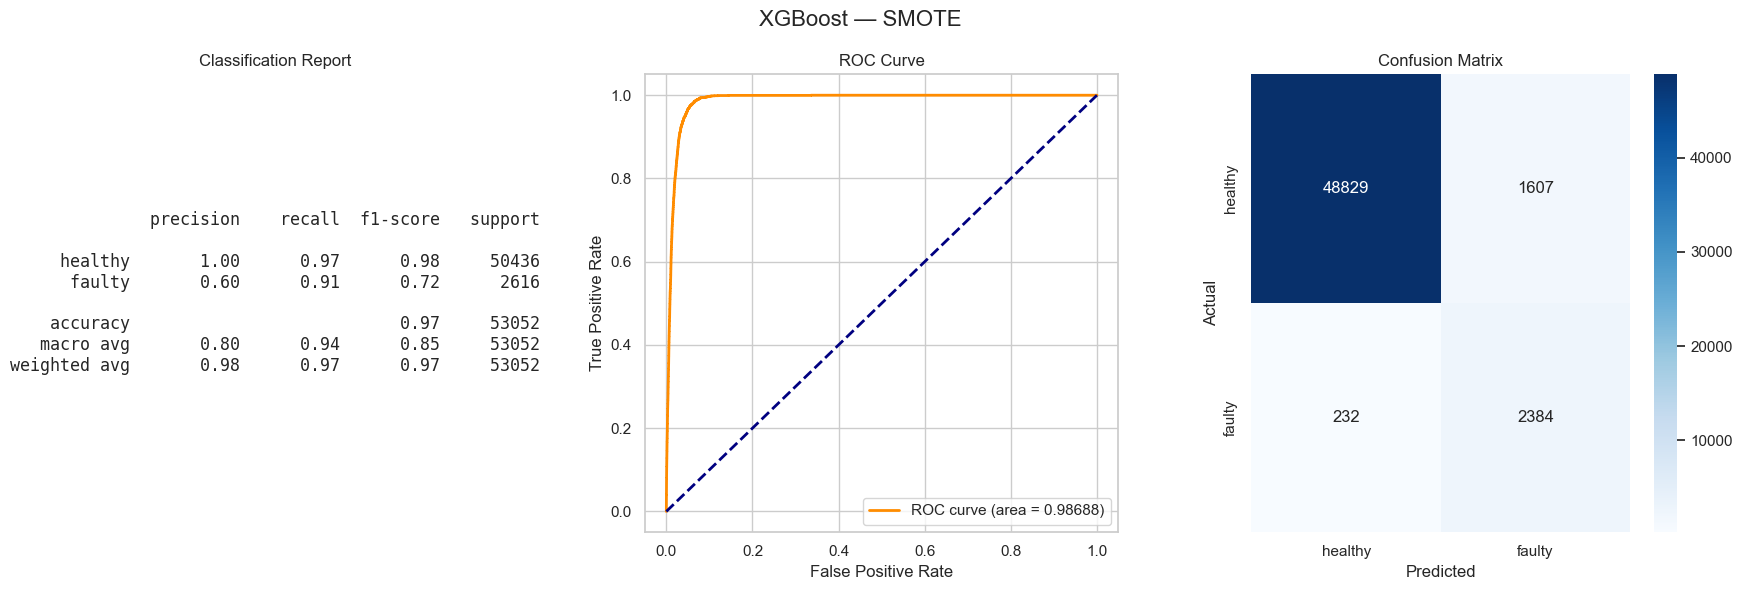

In [28]:
xgb_smote = XGBClassifier(n_estimators=100, random_state=42, tree_method='gpu_hist')
_ = run_model(xgb_smote, X_train_smote, y_train_smote, X_test, y_test, 'model_results.pkl', 'XGBoost — SMOTE', override=force_rerun)

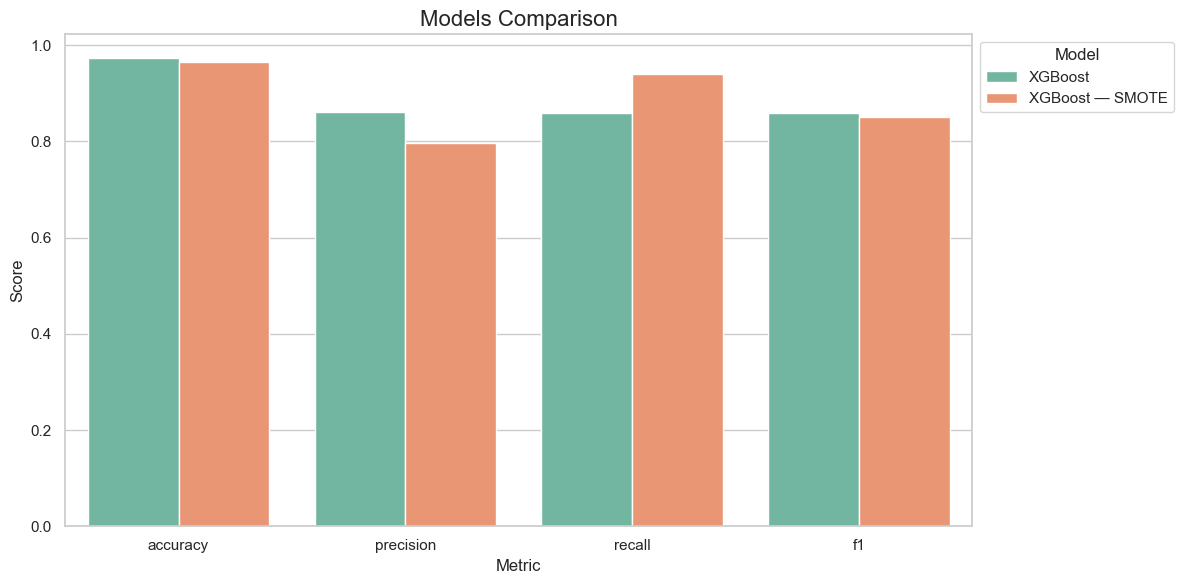

In [29]:
plot_comparison(hard_load('model_results.pkl'), ['XGBoost', 'XGBoost — SMOTE'])

## Undersampling

In [30]:
# Initialize RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply RandomUnderSampler
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# Check class distribution after RandomUnderSampler
print("Class distribution before RandomUnderSampler:\n", pd.Series(y_train).value_counts())
print("Class distribution after RandomUnderSampler:\n", pd.Series(y_train_under).value_counts())

Class distribution before RandomUnderSampler:
 failure_label
0    201739
1     10465
Name: count, dtype: int64
Class distribution after RandomUnderSampler:
 failure_label
0    10465
1    10465
Name: count, dtype: int64


### Random Forest

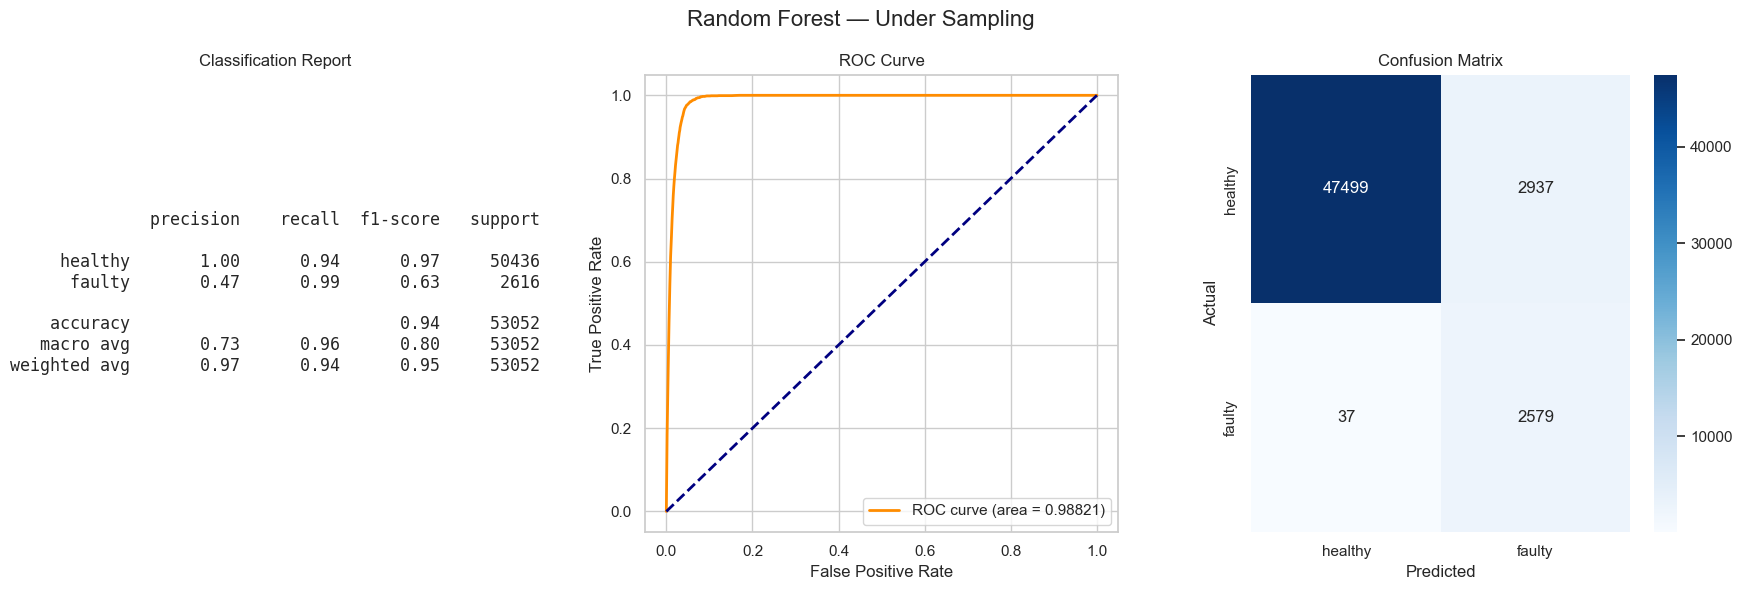

In [31]:
rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
_ = run_model(rf_under, X_train_under, y_train_under, X_test, y_test, 'model_results.pkl', 'Random Forest — Under Sampling', override=force_rerun)

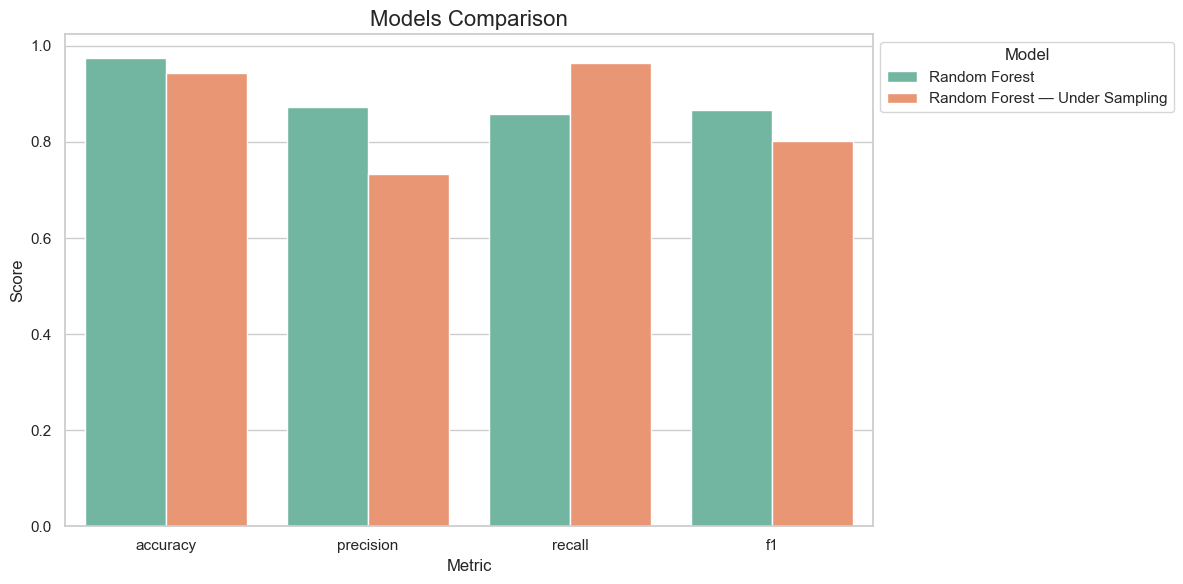

In [32]:
plot_comparison(hard_load('model_results.pkl'), ['Random Forest', 'Random Forest — Under Sampling'])

### Gradient Boosting

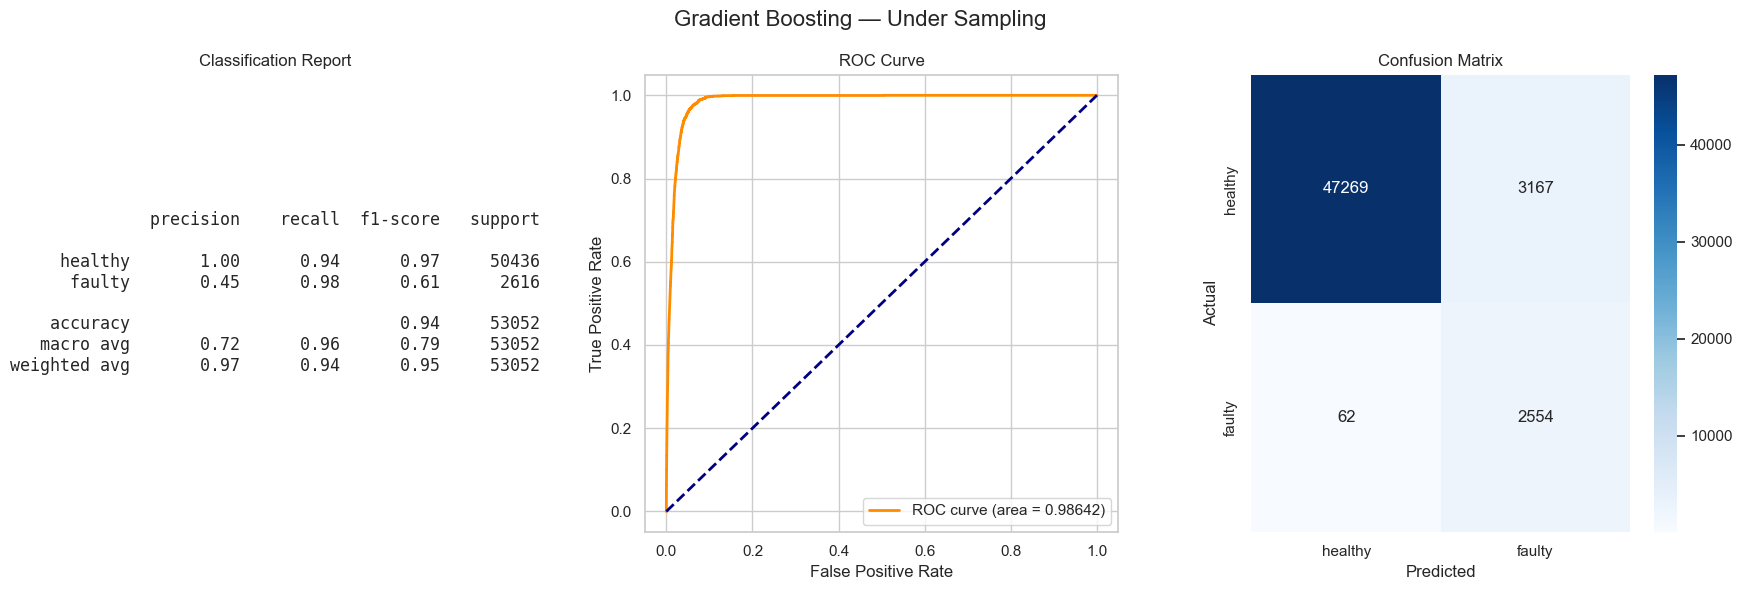

In [33]:
gb_under = GradientBoostingClassifier(n_estimators=100, random_state=42)
_ = run_model(gb_under, X_train_under, y_train_under, X_test, y_test, 'model_results.pkl', 'Gradient Boosting — Under Sampling', override=force_rerun)

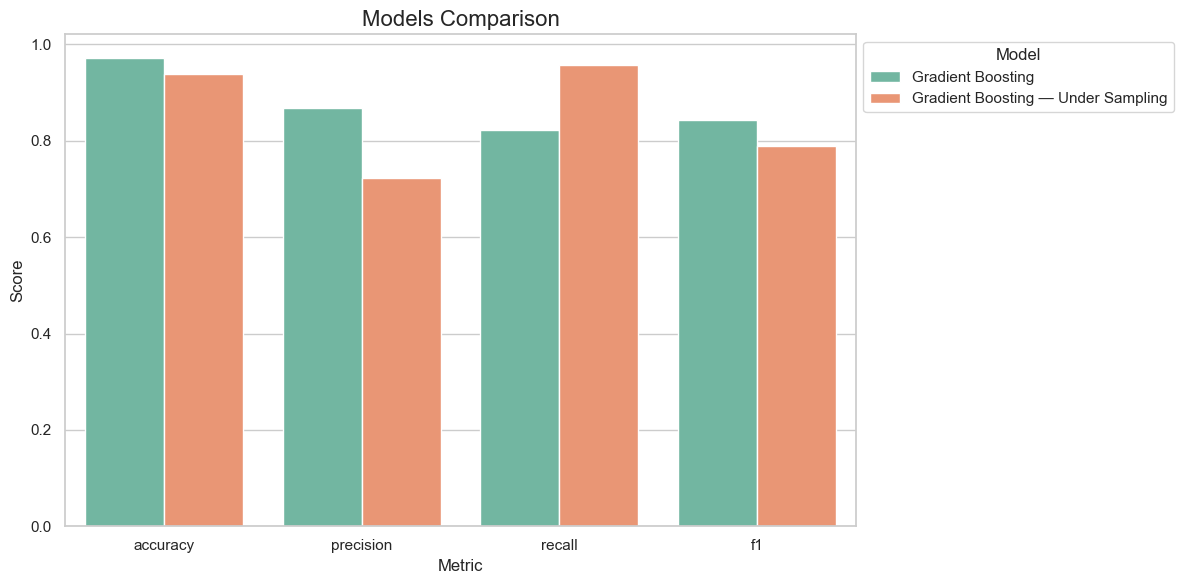

In [34]:
plot_comparison(hard_load('model_results.pkl'), ['Gradient Boosting', 'Gradient Boosting — Under Sampling'])

### XGBoost

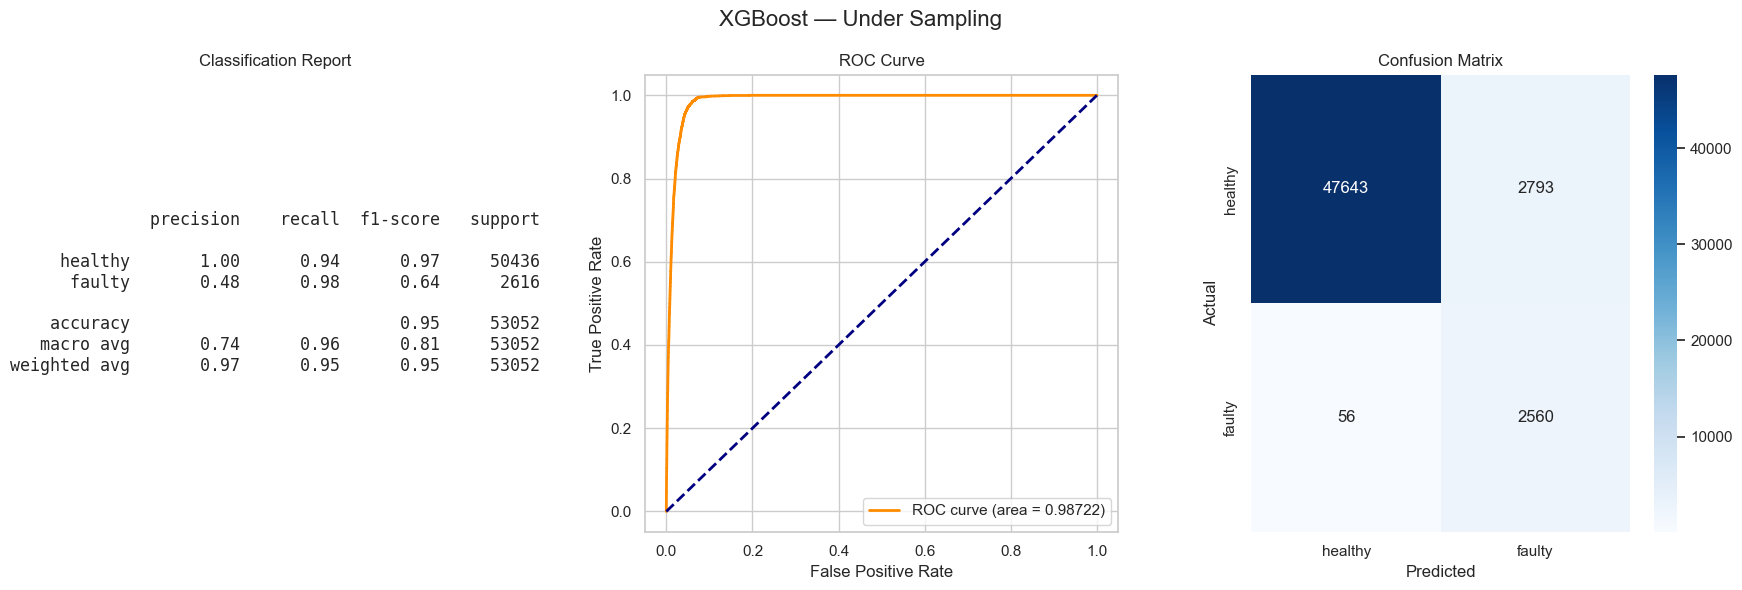

In [35]:
xgb_under = XGBClassifier(n_estimators=100, random_state=42, tree_method='gpu_hist')
_ = run_model(xgb_under, X_train_under, y_train_under, X_test, y_test, 'model_results.pkl', 'XGBoost — Under Sampling', override=force_rerun)

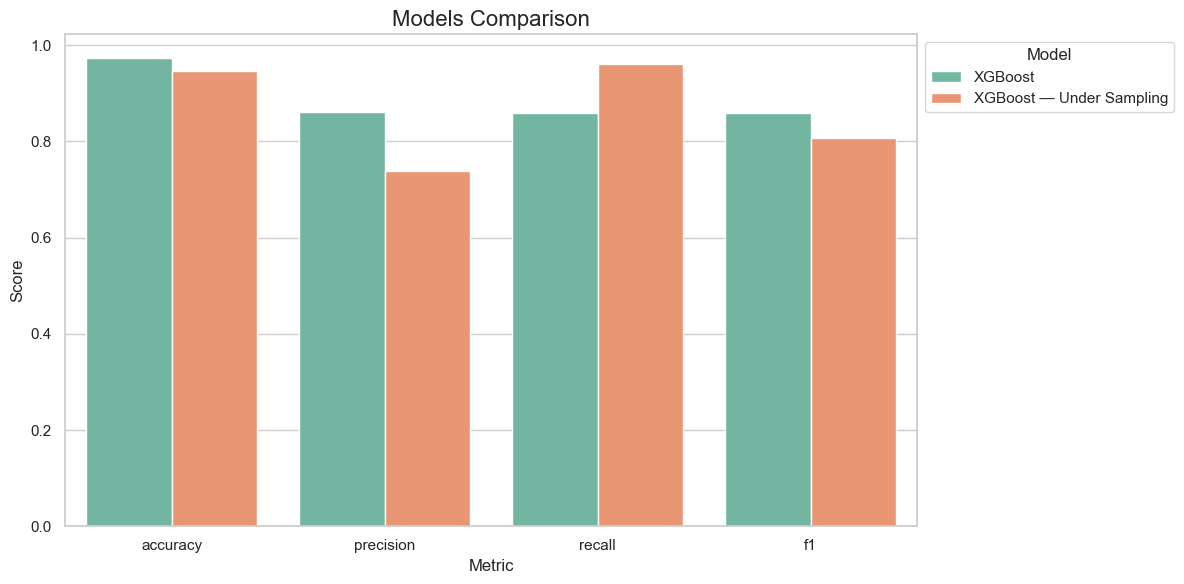

In [36]:
plot_comparison(hard_load('model_results.pkl'), ['XGBoost', 'XGBoost — Under Sampling'])

## SMOTEENN

In [37]:
smote_enn = SMOTEENN(random_state=42)

X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

# Check class distribution
print("Class distribution with only SMOTE:\n", pd.Series(y_train_smote).value_counts())
print("Class distribution after SMOTEENN:\n", pd.Series(y_train_smote_enn).value_counts())

Class distribution with only SMOTE:
 failure_label
0    201739
1    201739
Name: count, dtype: int64
Class distribution after SMOTEENN:
 failure_label
1    201504
0    192216
Name: count, dtype: int64


### Random Forest

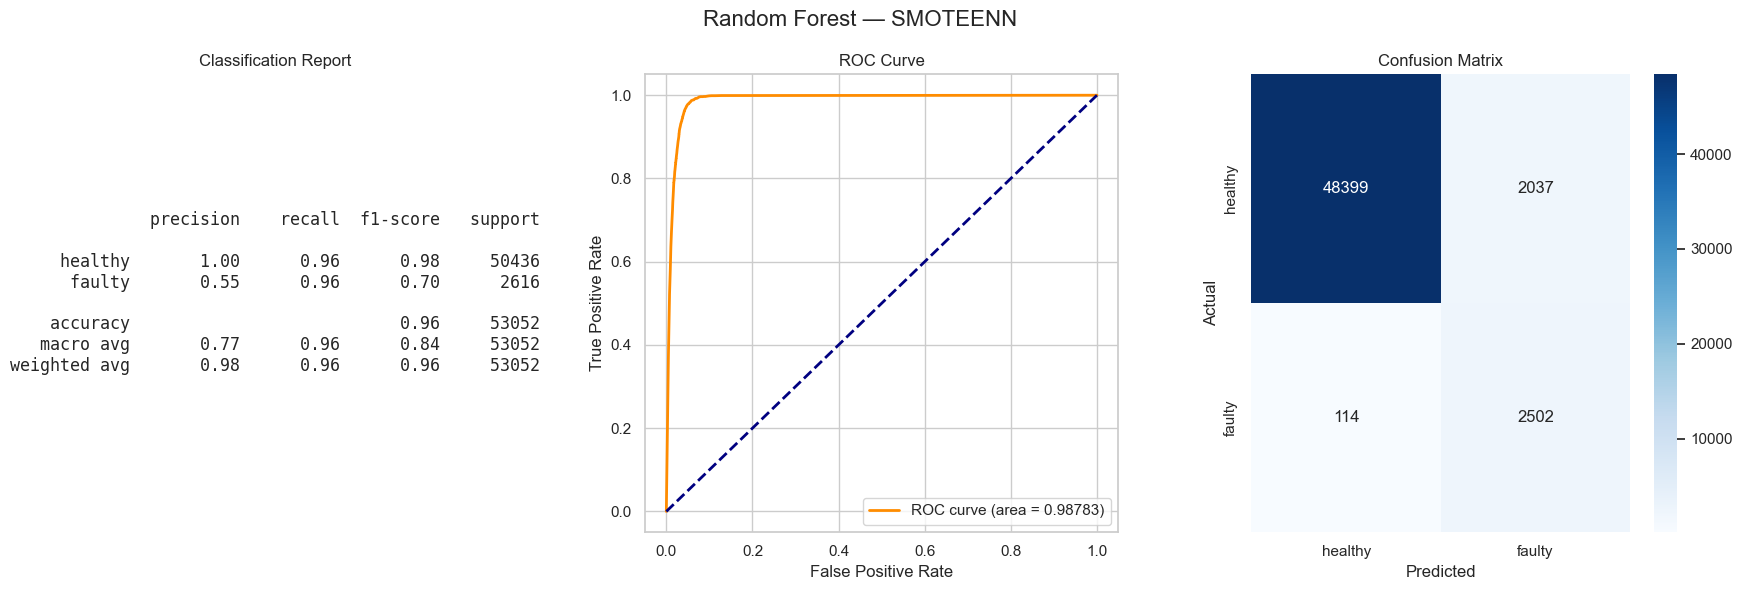

In [38]:
rf_smote_enn = RandomForestClassifier(n_estimators=100, random_state=42)
_ = run_model(rf_smote_enn, X_train_smote_enn, y_train_smote_enn, X_test, y_test, 'model_results.pkl', 'Random Forest — SMOTEENN', override=force_rerun)

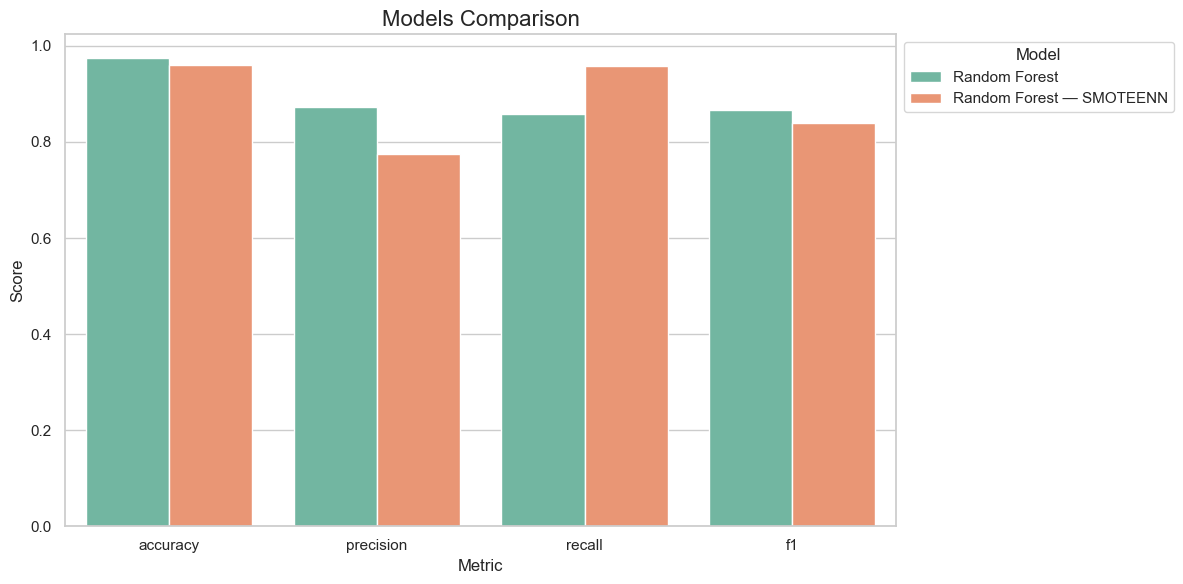

In [39]:
plot_comparison(hard_load('model_results.pkl'), ['Random Forest', 'Random Forest — SMOTEENN'])

### Gradient Boosting

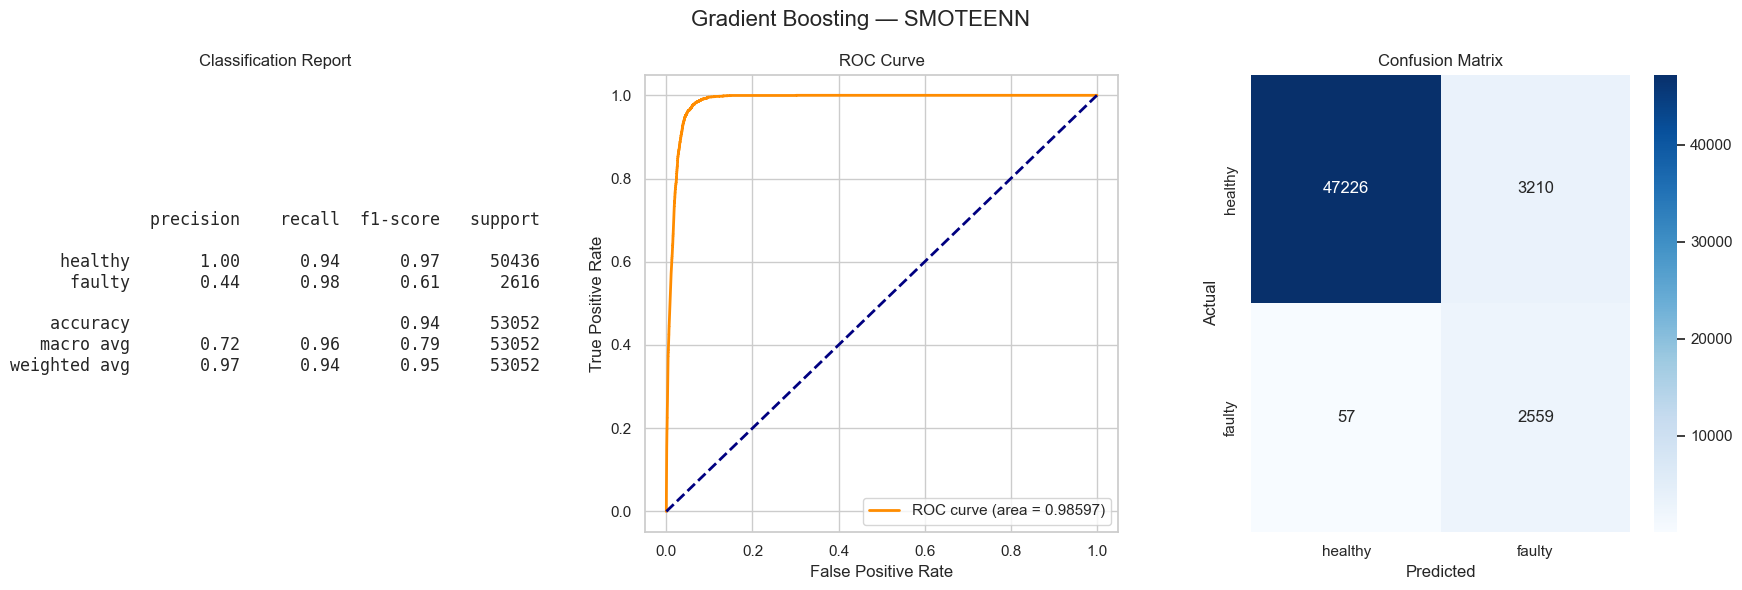

In [40]:
gb_smote_enn = GradientBoostingClassifier(n_estimators=100, random_state=42)
_ = run_model(gb_smote_enn, X_train_smote_enn, y_train_smote_enn, X_test, y_test, 'model_results.pkl', 'Gradient Boosting — SMOTEENN', override=force_rerun)

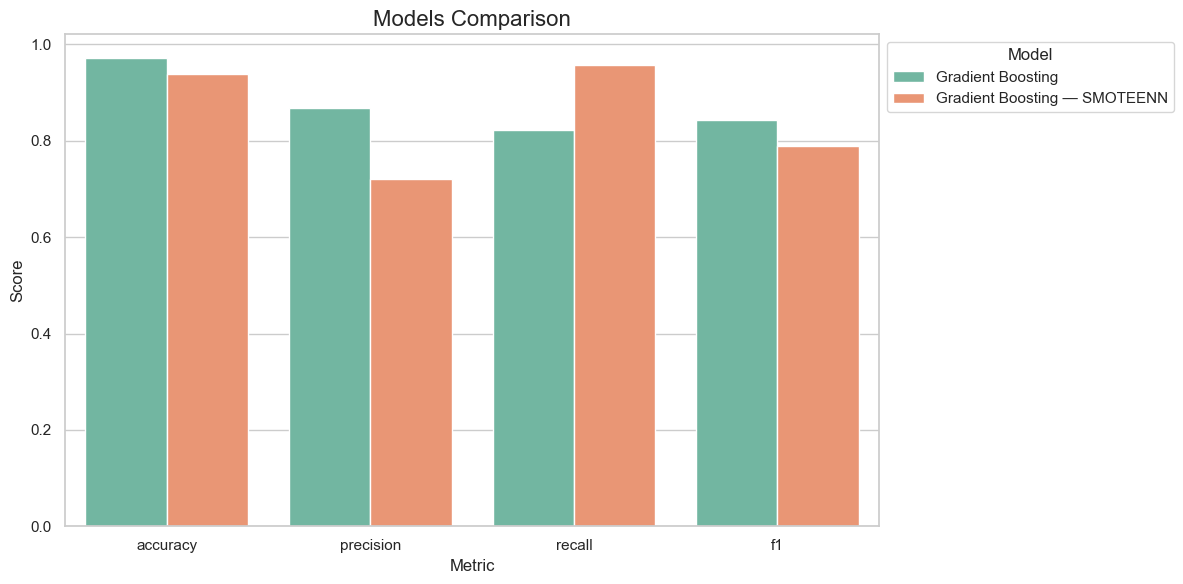

In [41]:
plot_comparison(hard_load('model_results.pkl'), ['Gradient Boosting', 'Gradient Boosting — SMOTEENN'])

### XGBoost

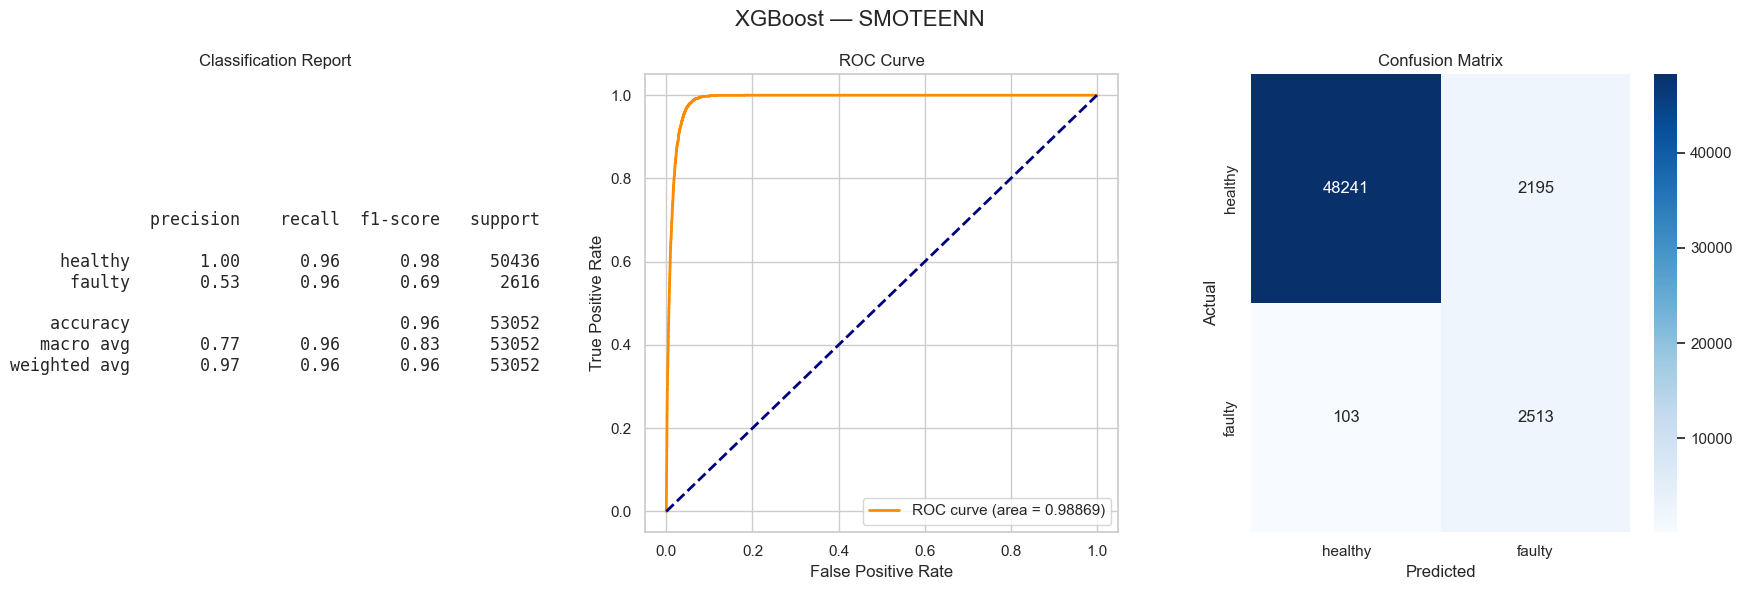

In [42]:
xgb_smote_enn = XGBClassifier(n_estimators=100, random_state=42, tree_method='gpu_hist')
_ = run_model(xgb_smote_enn, X_train_smote_enn, y_train_smote_enn, X_test, y_test, 'model_results.pkl', 'XGBoost — SMOTEENN', override=force_rerun)

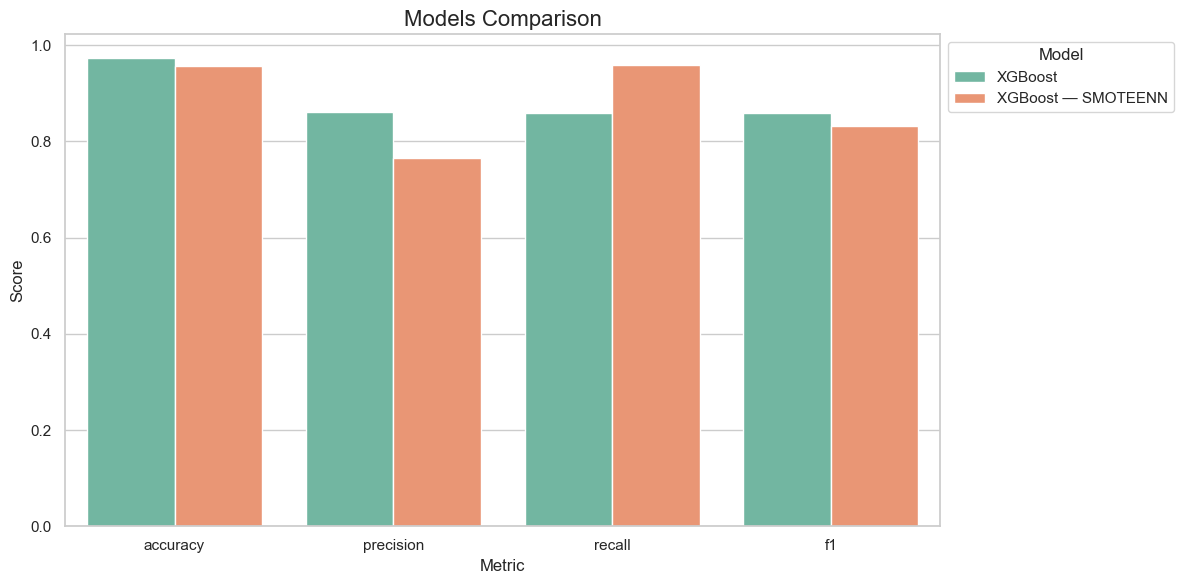

In [43]:
plot_comparison(hard_load('model_results.pkl'), ['XGBoost', 'XGBoost — SMOTEENN'])

## Cost sensitive learning

In [44]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Computed Class Weights: {class_weights_dict}")

Computed Class Weights: {0: 0.5259369779764944, 1: 10.138748208313425}


### Random Forest

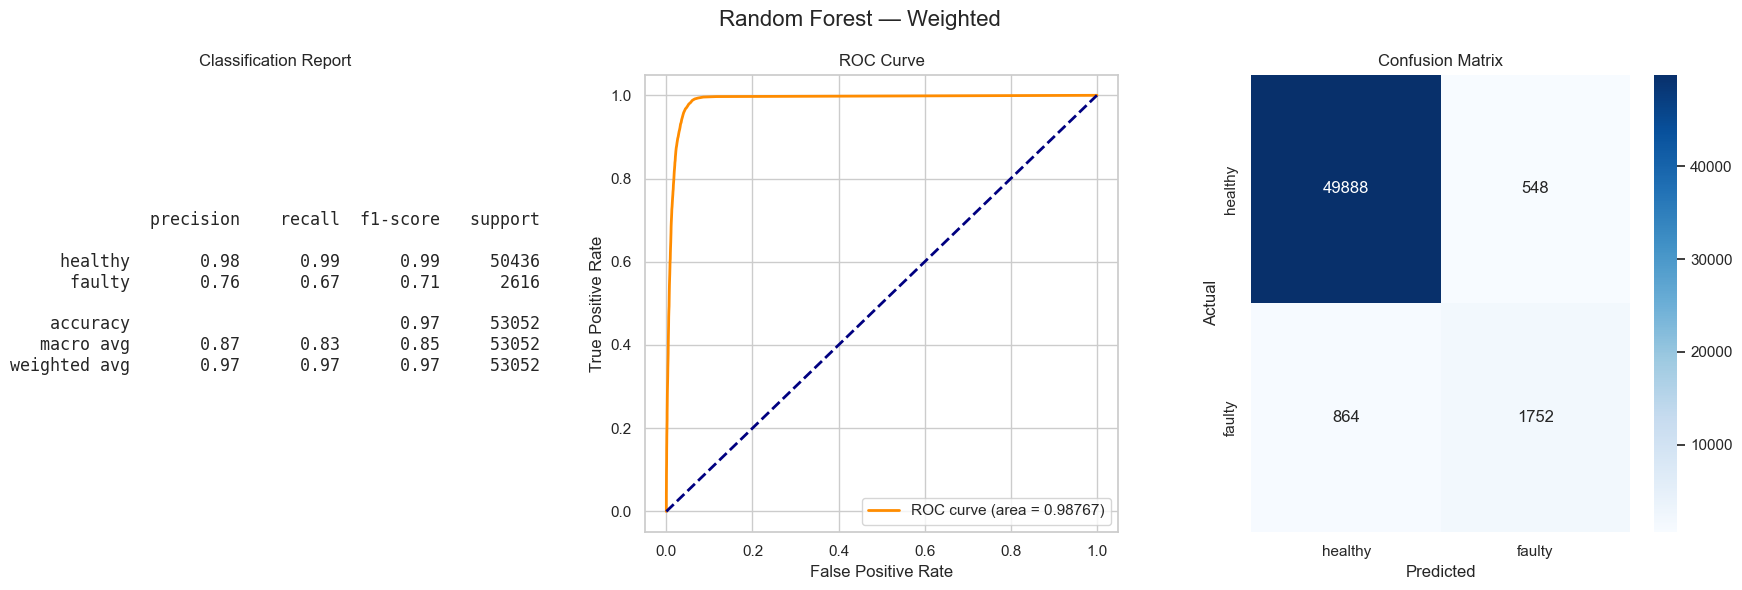

In [45]:
rf_weighted = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)
_ = run_model(rf_weighted, X_train, y_train, X_test, y_test, 'model_results.pkl', 'Random Forest — Weighted', override=force_rerun)

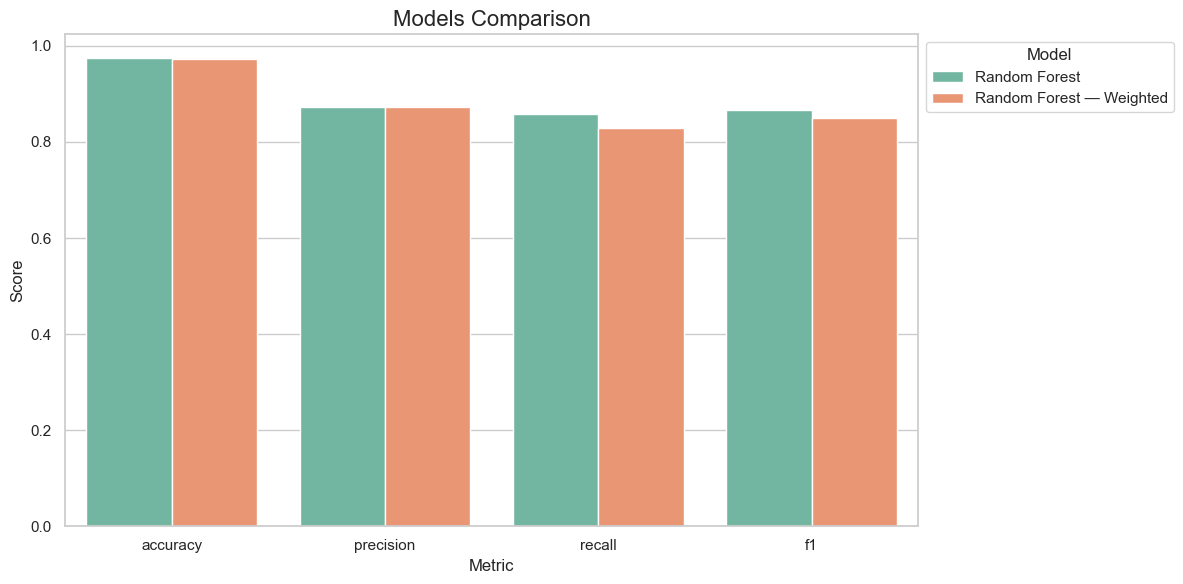

In [46]:
plot_comparison(hard_load('model_results.pkl'), ['Random Forest', 'Random Forest — Weighted'])

### Gradient Boosting

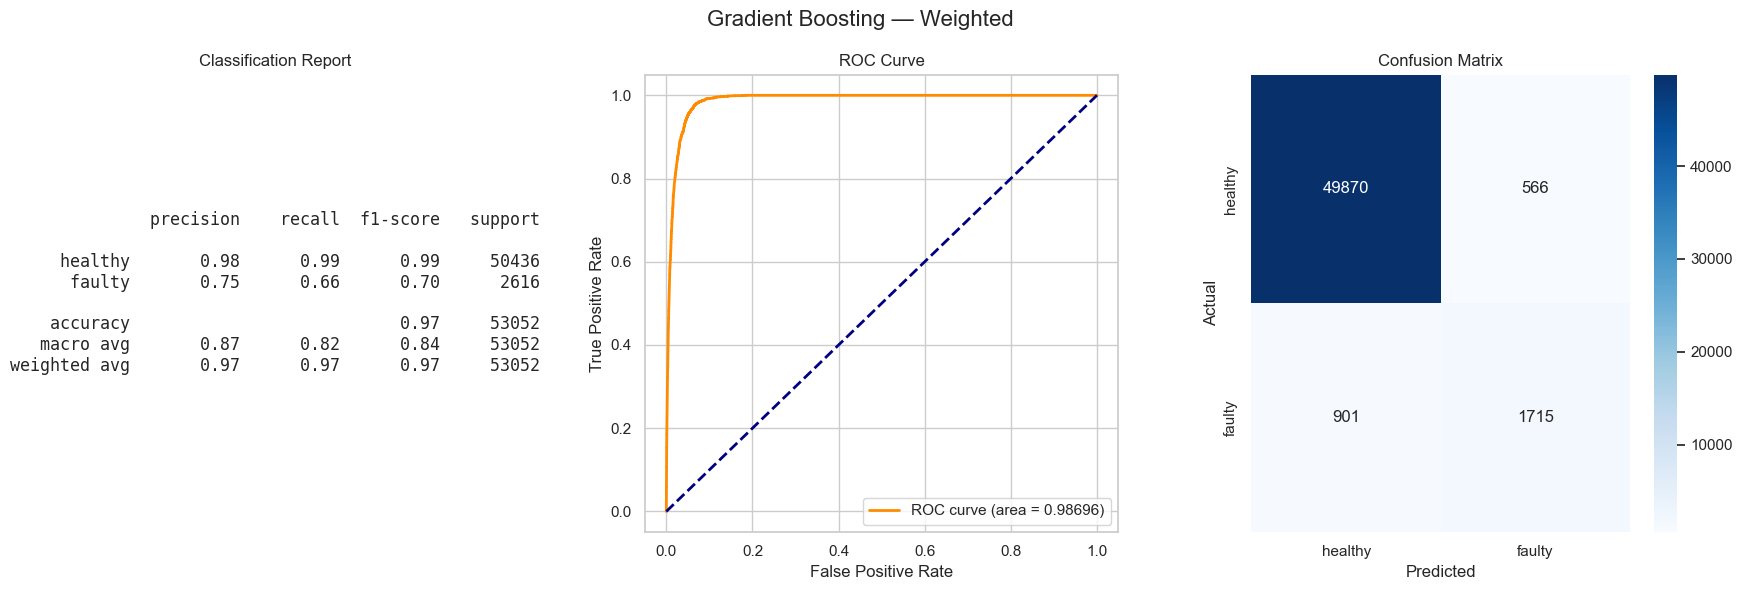

In [47]:
gb_weighted = GradientBoostingClassifier(n_estimators=100, random_state=42)
_ = run_model(gb_weighted, X_train, y_train, X_test, y_test, 'model_results.pkl', 'Gradient Boosting — Weighted', override=force_rerun)

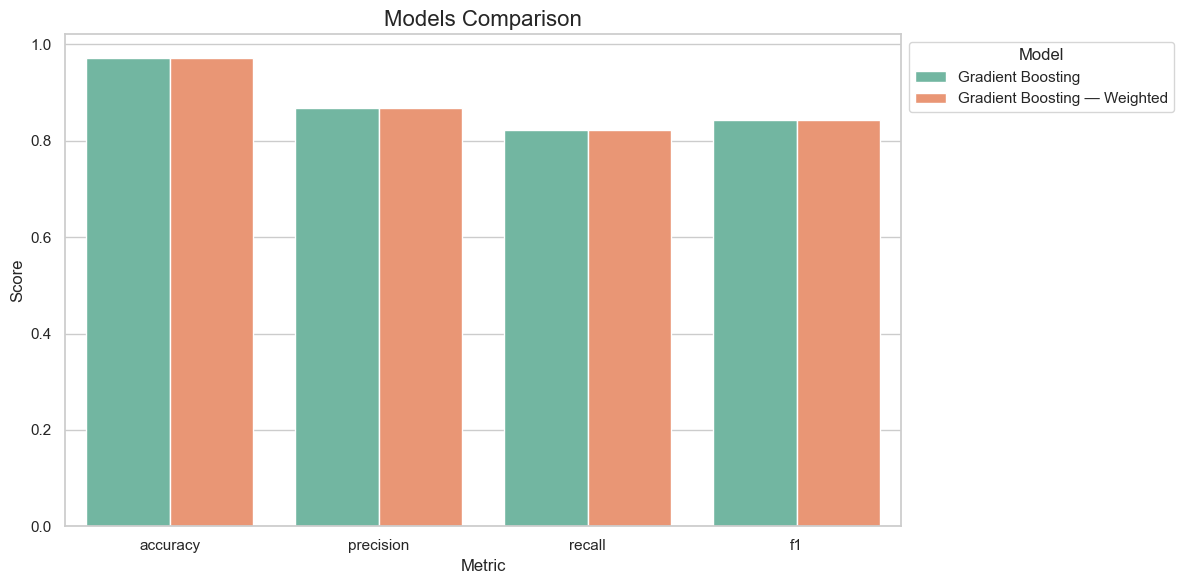

In [48]:
plot_comparison(hard_load('model_results.pkl'), ['Gradient Boosting', 'Gradient Boosting — Weighted'])

### XGBoost

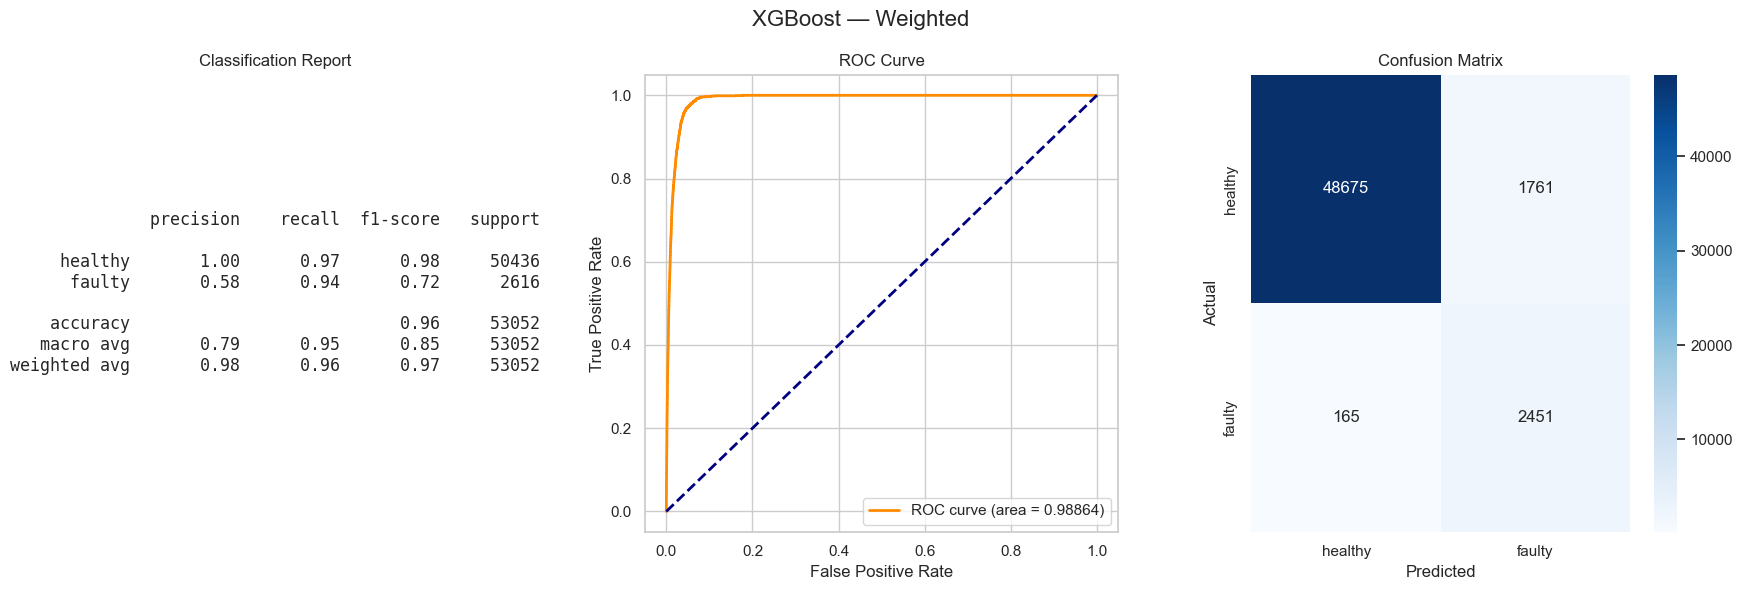

In [49]:
xgb_weighted = XGBClassifier(n_estimators=100, scale_pos_weight=class_weights_dict[1], random_state=42, tree_method='gpu_hist')
_ = run_model(xgb_weighted, X_train, y_train, X_test, y_test, 'model_results.pkl', 'XGBoost — Weighted', override=force_rerun)

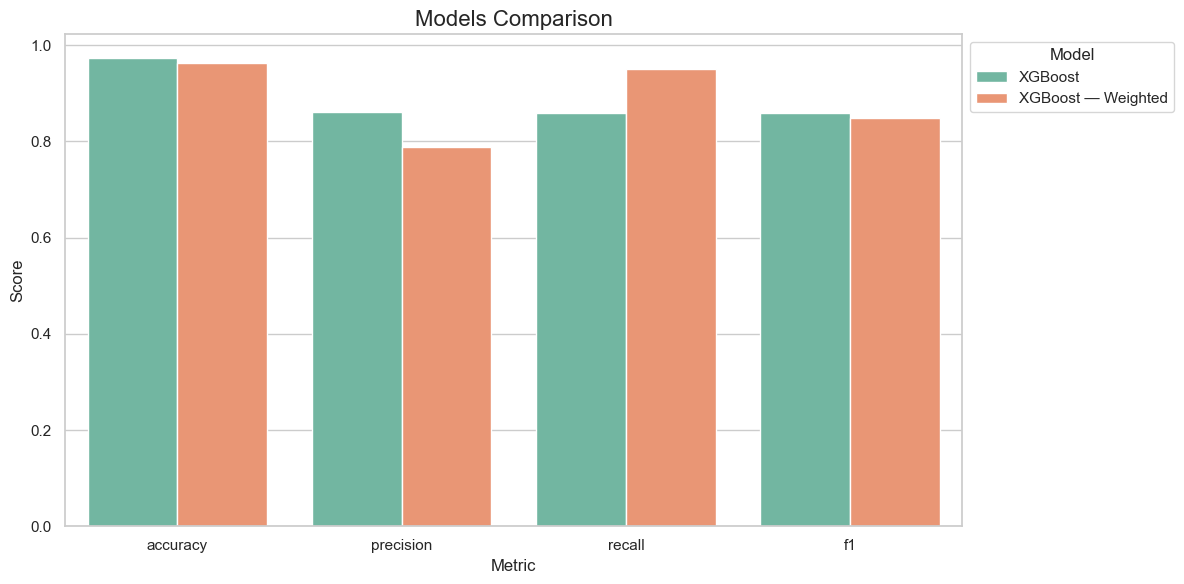

In [50]:
plot_comparison(hard_load('model_results.pkl'), ['XGBoost', 'XGBoost — Weighted'])

## Comparison

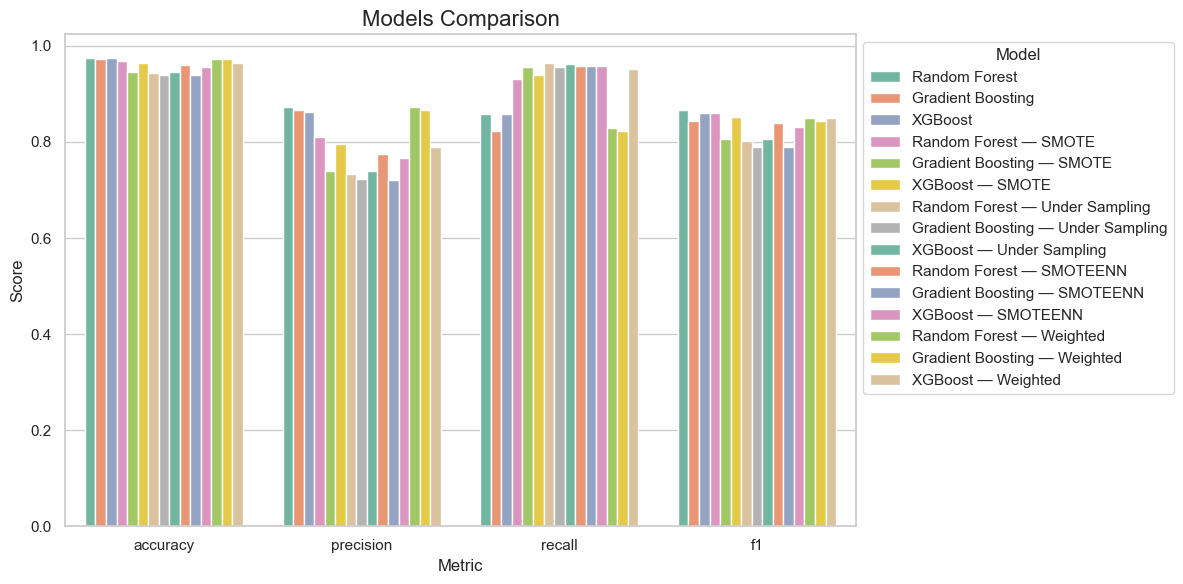

In [51]:
plot_comparison(hard_load('model_results.pkl'),
                ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Random Forest — SMOTE', 'Gradient Boosting — SMOTE',
                 'XGBoost — SMOTE', 'Random Forest — Under Sampling', 'Gradient Boosting — Under Sampling',
                 'XGBoost — Under Sampling', 'Random Forest — SMOTEENN', 'Gradient Boosting — SMOTEENN',
                 'XGBoost — SMOTEENN', 'Random Forest — Weighted', 'Gradient Boosting — Weighted',
                 'XGBoost — Weighted'])

All three models (Random Forest, Gradient Boosting, and XGBoost) exhibit similar performance trends across the different metrics, suggesting that the dataset properties have a uniform impact on these algorithms.

Accuracy scores are consistently high for all models and dataset-handling techniques.
However, since the dataset is imbalanced, accuracy alone might not be a reliable indicator of performance. **f1** might provide a more comprehensive evaluation.

It can be noticed that **recall** improves significantly when SMOTE is applied, particularly for Gradient Boosting and XGBoost.
This indicates that SMOTE helps in correctly identifying the minority class (failures), reducing false negatives.
However, there’s a slight trade-off in **precision**, as synthetic samples might introduce noise.
On the other hand, models trained with SMOTEENN achieve a good balance between **precision** and **recall**, resulting in high **F1-scores**.
This suggests that SMOTEENN effectively cleans noisy synthetic samples created by SMOTE while improving the minority class's representation.

The models can be compared transversely:
- **Random Forest**:
    Performs consistently well across all metrics but slightly lags behind Gradient Boosting and XGBoost in terms of **recall**.
    This could indicate that Random Forest struggles slightly more with the imbalanced dataset.
- **Gradient Boosting**:
    Performs better than Random Forest in **recall**, especially when SMOTE or SMOTEENN is applied.
    Gradient Boosting appears to benefit more from sampling techniques that balance the dataset.
- **XGBoost**:
   XGBoost achieves the highest scores across most metrics, particularly when SMOTEENN or class weighting is applied.
   Its robustness and ability to handle imbalanced datasets make it the top-performing model in this comparison, making it a candidate as the best model among the three.

# Step 5: Maintenance Scheduling Using Reinforcement Learning

## Environment

The environment is defined as a class `MaintenanceEnv` that takes the preprocessed dataset as input and provides a reinforcement learning environment for maintenance scheduling.

The environment has been defined with the following characteristics:
- **State Space**:
The environment uses a discretized state space via KMeans clustering of sensor data. Each state represents a cluster that captures similar operational conditions.
This simplifies the state representation while preserving the most relevant features for decision-making.
- **Action Space**:
The agent can choose between two actions: 0 (No Maintenance) and 1 (Perform Maintenance). This directly aligns with maintenance scheduling decisions.
- **Reward System**:
The reward structure penalizes failures heavily, incentivizes proactive maintenance in high-risk conditions (low Remaining Useful Life, RUL), and provides positive rewards for avoiding unnecessary maintenance in safe states.
The scaled rewards align with minimizing costs associated with downtime (failures) and maintenance.


In [52]:
class MaintenanceEnv:
    def __init__(self, df, n_clusters=24):
        self.df = df.reset_index(drop=True)
        self.current_index = 0
        self.sensor_columns = [col for col in df.columns if col.startswith("sensor_")]
        self.action_space = [0, 1]  # Action space: No maintenance (0), Perform maintenance (1)
        self.state = None

        # Discretize sensor data using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        sensor_data = df[self.sensor_columns].values
        self.state_bins = kmeans.fit_predict(sensor_data)

        self.n_clusters = n_clusters  # Discrete size of state space

    def reset(self):
        self.current_index = 0
        self.state = self.state_bins[self.current_index]
        return self.state

    def step(self, action):
        maintenance_cost = -10 if action == 1 else 0  # Cost for performing maintenance

        current_rul = self.df.loc[self.current_index]["RUL"]

        # Calculate the reward
        if current_rul == 0:  # Failure state
            if action == 1:  # Perform maintenance
                reward = -50  # Reduced penalty for maintenance
            else:  # No maintenance
                reward = -100  # Large penalty
        elif current_rul <= failure_threshold:  # Faulty state
            if action == 1:  # Perform maintenance
                reward = 110 + maintenance_cost  # Large reward
            else:  # No maintenance
                reward = -80  # Penalty
        else:  # Healthy state
            if action == 1:  # Perform maintenance
                reward = maintenance_cost  # Cost of maintenance
            else:  # No maintenance
                reward = 30  # Reward for no maintenance in normal state

        reward = reward / 100  # Scale all rewards by 1/100

        # Move to the next state
        self.current_index += 1
        done = self.current_index >= len(self.df)

        if not done:
            self.state = self.state_bins[self.current_index]
        else:
            self.state = None

        return self.state, reward, done


## Q-Learning and policy evaluation

The Q-learning algorithm is used.

The defined algorithm follows these key steps:
- Explores different state-action pairs (via epsilon-greedy action selection).
- Updates the Q-table to reflect the cumulative reward for each state-action pair.
- Decays the exploration rate (epsilon) to transition from exploration to exploitation over time.

The learned Q-table represents the agent's knowledge of the environment and allows the agent to select the optimal action for any given state.

The trained policy is evaluated on new episodes to measure its average reward, reflecting its effectiveness in balancing downtime and maintenance costs.

In [53]:
def q_learning(env, episodes=1000, alpha=0.5, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, save_to="q_table.npy", override=False):
    n_actions = len(env.action_space)
    n_states = env.n_clusters

    if os.path.exists(save_to) and not override:
        print("Loading saved Q-Table...")
        q_table = np.load(save_to)
        return q_table

    q_table = np.zeros((n_states, n_actions))  # Initialize the Q-table

    for episode in tqdm(range(episodes), desc="Training Progress"):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Action selection: Epsilon-Greedy
            if np.random.rand() < epsilon:
                action = random.choice(env.action_space)  # Exploration
            else:
                action = np.argmax(q_table[state, :])    # Exploitation using optimal policy

            # Perform action
            next_state, reward, done = env.step(action)

            # Update Q-value
            if next_state is not None:
                q_table[state, action] += alpha * (
                        reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
                )

            # Update state and total reward
            state = next_state
            total_reward += reward

        # Decay exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Save progress periodically
        if (episode + 1) % 100 == 0:
            np.save(save_to, q_table)

    np.save(save_to, q_table)
    return q_table

def evaluate_policy(env, q_table, episodes=100):
    total_rewards = []
    for _ in tqdm(range(episodes), desc="Evaluating Policy"):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Select action based on the learned policy
            action = np.argmax(q_table[state, :])
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
        total_rewards.append(total_reward)
    return np.mean(total_rewards), total_rewards  # Return the average and total reward

def visualize_policy(q_table, sample_size=100):
    actions = []
    for i in range(sample_size):
        state_index = i % q_table.shape[0]   # index in q-table
        action = np.argmax(q_table[state_index, :])
        actions.append(action)

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(range(sample_size), actions, c=actions, cmap='coolwarm', alpha=0.6, edgecolor='k', s=100)
    plt.xlabel("Steps")
    plt.ylabel("Action (0: No Maintenance, 1: Maintenance)")
    plt.title(f"Actions Taken (First {sample_size} Steps)")
    plt.show()

def visualize_q_table(q_table):
    plt.figure(figsize=(10, 6))
    sns.heatmap(q_table, annot=True, cmap='Blues', linewidths=0.5)
    plt.title('Q-Table Values (Learned Q-values)')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.show()

## Usage

The environment is created (as explained above) using a sampled dataset, and the Q-learning algorithm (described above) is used. The Q-table is then evaluated to measure the average reward of the trained policy.

Only a subset of the dataset (20%) is used for training due to the computational demand of the Q-learning algorithm.

In [54]:
RL_columns = [feat for feat in features_in_use if not feat.endswith('_avg')]
RL_columns += ['RUL']

df_sampled = df_preprocessed[RL_columns]
df_sampled = df_sampled.iloc[:int(len(df_sampled) * 0.2)]
env = MaintenanceEnv(df_sampled)

# Execute Q-Learning training
q_table = q_learning(env,
                     episodes=2000,         # number of episodes
                     alpha=0.7,             # learning rate
                     gamma=0.95,            # discount factor
                     epsilon=1.0,           # initial exploration rate
                     epsilon_decay=0.999,   # exploration rate decay
                     min_epsilon=0.05,      # minimum exploration rate
                     save_to="q_table.npy", # file to save Q-table
                     override=force_rerun)

# Evaluate the policy
average_reward, total_rewards = evaluate_policy(env, q_table, episodes=100)
print(f"Average Reward: {average_reward:.0f}")

Loading saved Q-Table...


Evaluating Policy: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

Average Reward: 14023


The obtained average reward suggests that the policy performs well, avoiding significant failures and managing maintenance effectively. To confirm, we should compare it against a baseline and analyze the specific maintenance and failure outcomes. A random policy as a baseline for comparison can be used.

In [55]:
def random_policy(env, episodes=100):
    total_rewards = []
    for _ in tqdm(range(episodes), desc="Evaluating Random Policy"):
        env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.random.choice(env.action_space)  # Random action
            next_state, reward, done = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    return np.mean(total_rewards)

random_score = random_policy(env, episodes=100)
print(f"Random Policy Score: {random_score:.0f}")

Evaluating Random Policy: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]

Random Policy Score: 5120


The significantly higher score of the learned policy, compared to the random one, confirms that the RL agent has learned an effective predictive maintenance strategy. It successfully minimizes failures and avoids unnecessary maintenance compared to a random policy.

### Policy Visualization

The actions taken by the policy can be visualized to understand the agent's decision-making process.

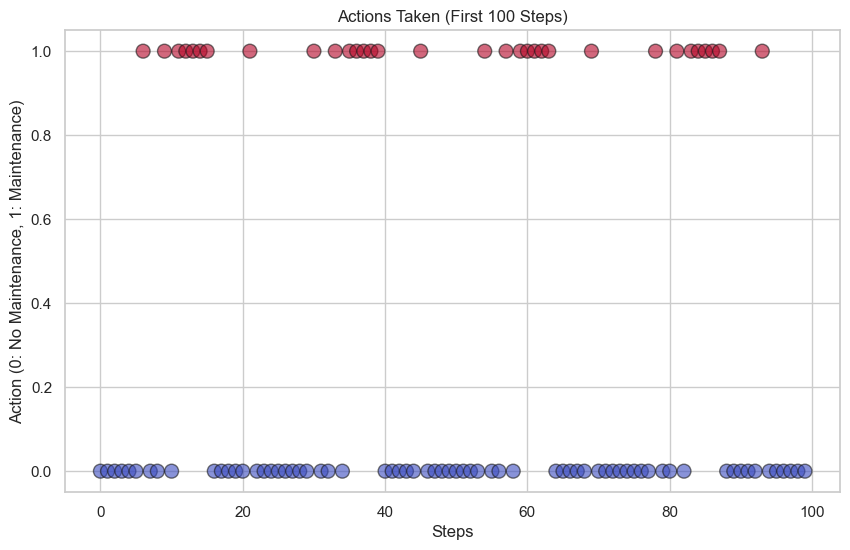

In [56]:
# Visualize actions taken by the policy
visualize_policy(q_table, sample_size=100)

Some considerations from the policy visualization can be made:
- **frequent switching between actions**:
The agent alternates frequently between the 2 actions.
This suggests the policy is dynamically reacting to the current state and reward system.
- **predictable pattern**:
The agent tends to perform maintenance (action 1) after periods of no maintenance (action 0), which could correspond to when the agent anticipates a failure.
- **proactive maintenance**:
Maintenance is not evenly distributed but rather concentrated in specific intervals. This suggests the agent is making decisions based on the state or RUL.

### Q-Table Visualization

The Q-table can be visualized to understand the learned Q-values for each state-action pair.

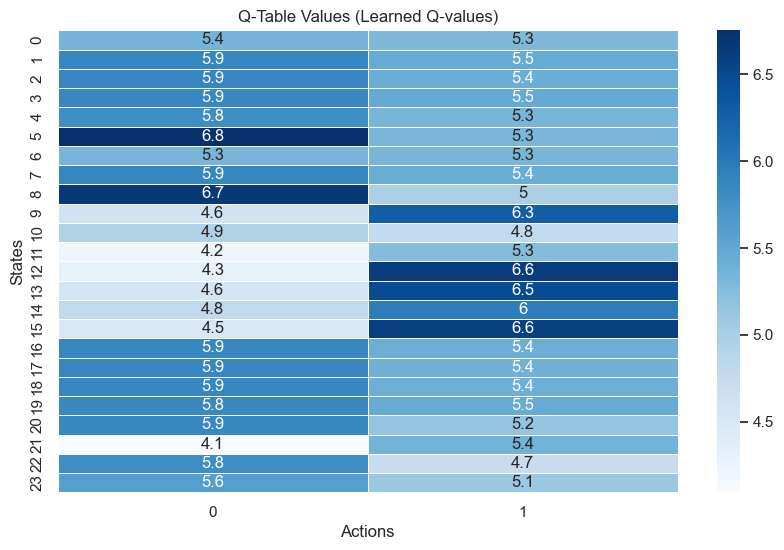

In [57]:
visualize_q_table(q_table)

We can make some observations from the Q-table:
- **q-values are higher for action 1 (maintenance)**:
    For some states (like states 10, 14, 15), the q-value for action 1 is higher than for action 0.
    This suggests that performing maintenance in these states is preferred, likely because they represent a condition with a low RUL.
- **q-values are generally balanced**:
In several states the q-values for both actions are relatively close.
This indicates that the agent perceives little difference between performing maintenance or not in these states, suggesting they may represent healthy operational conditions (with a higher RUL).
- **cluster of higher or lower q-values can be observed**:
Certain regions of the Q-table show consistently higher or lower values, indicating distinct clusters of states where maintenance or no maintenance is generally preferred.

In conclusion the agent has successfully learned a policy by associating specific actions with states to maximize the cumulative reward.
We can also notice how the distribution of q-values reflects the reward structure. For example:
- high penalties for failure push the agent to prefer maintenance in high-risk states.
- maintenance costs incentivize avoiding unnecessary maintenance in low-risk states.

# Step 6: Model Selection and Hyperparameter Tuning with AutoML

## TPOT: Automated Machine Learning

For the automated ML, the TPOT library is used, as shown during the labs.

The classifier is optimized for the F1-score, which is a suitable metric for imbalanced classification tasks like predictive maintenance. A sufficient amount of `generations` and `population_size` are used to explore the search space effectively.

The warning about the feature names can be safely ignored, as the issue is separately addressed.

In [58]:
results = hard_load('model_results.pkl')
if not results.get('TPOT'):
    # Initialize the TPOT Classifier
    tpot = TPOTClassifier(
        memory='auto',                                  # Use memory efficiently
        generations=10,                                 # Number of generations to run
        population_size=50,                             # Number of individuals in each generation
        cv=5,                                           # 5-fold cross-validation
        scoring='f1',                                   # Optimize for F1-score
        random_state=42,
        verbosity=2 ,                                   # Show progress
        n_jobs=-1,                                      # Use all available cores
        periodic_checkpoint_folder='tpot_checkpoints',  # Save checkpoints
        early_stop=2                                    # Early stopping
    )
    
    tpot.fit(X_train, y_train)
    
    score = tpot.score(X_test, y_test)
    print(f"Best score: {score}")
    
    best_pipeline_string = tpot.export()
    
    autoML_best_model = tpot.fitted_pipeline_
else:
    print("Loading best pipeline from memory...")
    
    autoML_best_model = results['TPOT']['model']
    cv_scores = cross_val_score(autoML_best_model, X_train, y_train, cv=5, scoring='f1')
    score = cv_scores.mean()
    print(f"Best score: {score}")
    
    best_pipeline_string = None

autoML_best_model

Loading best pipeline from memory...


/opt/anaconda3/envs/AMLI-project/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/AMLI-project/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/AMLI-project/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/AMLI-project/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/AMLI-project/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with featur

Best score: 0.7622059348752099


Pipeline(memory=Memory(location=/var/folders/yg/gp8smp8d1cx2j1t_sxxl13580000gn/T/tmp2uz2riz2/joblib),
         steps=[('stackingestimator',
                 StackingEstimator(estimator=ExtraTreesClassifier(max_features=0.9500000000000001,
                                                                  min_samples_split=8,
                                                                  random_state=42))),
                ('gaussiannb', GaussianNB())])

The obtained score of 0.76 of the resulting model of the AutoML process seems in line with the previous models, but the F1-score is a more reliable metric for imbalanced classification tasks. The model will be further evaluated and compared with the previous ones in the following parts.

## Workflow automation

The best pipeline is store in the `best_pipeline.py` file, after some adjustments are made to the code provided automatically from the `tpot.export()` method. Specifically, the code is updated so that it correctly imports and splits the already preprocessed data (saved in the `df_preprocessed.pkl` file earlier).

In [59]:
if best_pipeline_string is not None:
    
    hard_save_string = """
    def hard_load(file):
        try:
            with open(file, 'rb') as f:
                return pickle.load(f)
        except FileNotFoundError:
            print(f'File {file} not found')
            exit(1)
        except Exception as e:
            print(f'Error loading file {file}: {e}')
            exit(1)
    """
    
    best_pipeline_string = "import pickle\n" + best_pipeline_string
    
    fix_data_splitting = f"""
    {hard_save_string}
    tpot_data = hard_load('df_preprocessed.pkl')
    features = {features_in_use}
    X = tpot_data[features]
    y = tpot_data['failure_label']
    training_features, testing_features, training_target, testing_target = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    """
    pattern = r"tpot_data =.+\nfeatures =.+\ntraining_features, testing_features, training_target, testing_target =.+\n.+\n"
    
    # Replace the matched substring with the fix_data content
    best_pipeline_string = re.sub(pattern, fix_data_splitting, best_pipeline_string)
    
    try:
        with open('best_pipeline.py', 'w') as file:
            file.write(best_pipeline_string)
        print(f"best_pipeline.py saved successfully")
    except Exception as e:
        print(f"An error occurred while saving the bext pipeline: {e}")
        print("best pipeline:")
        print(best_pipeline_string)
else:
    print("Best pipeline already saved")

Best pipeline already saved


## Comparison

The obtained best model from autoML is now evaluated and compared with the previous models.

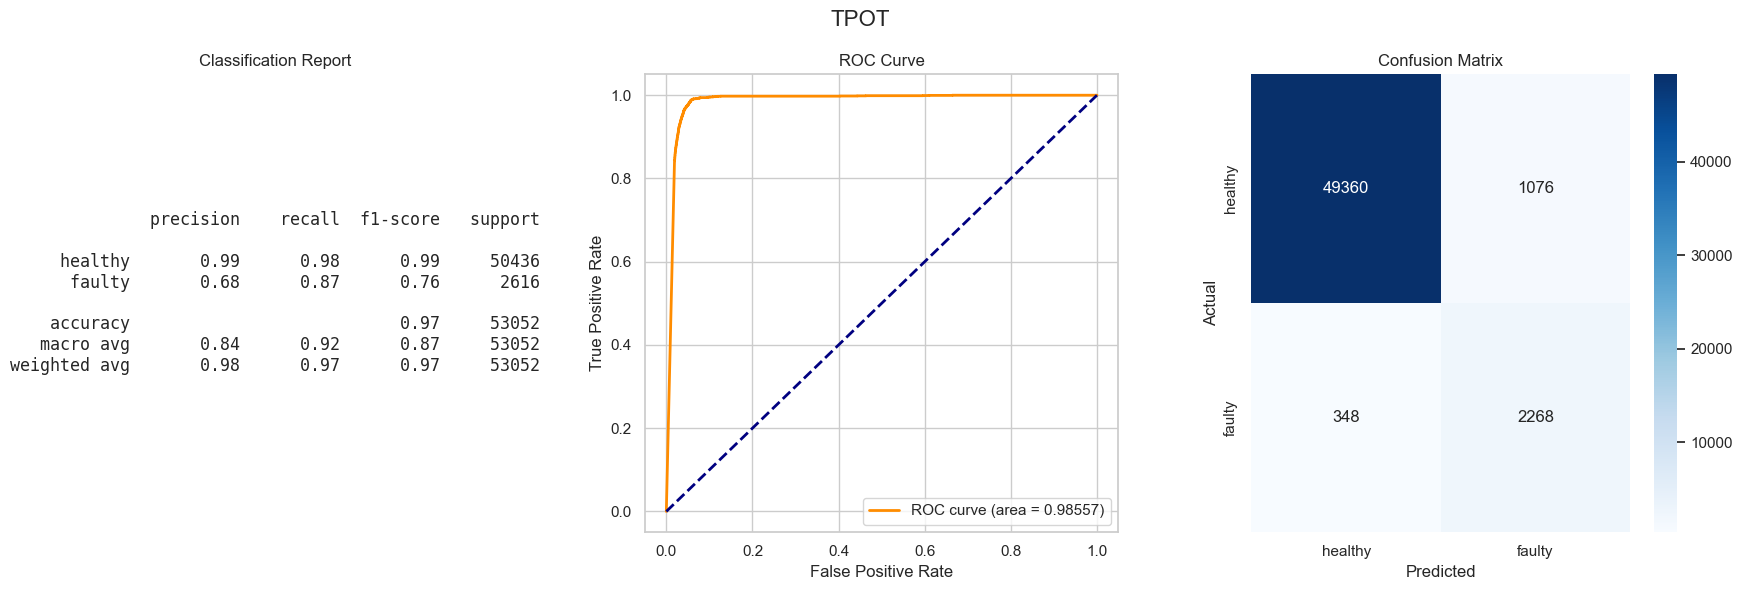

In [60]:
_ = run_model(autoML_best_model, X_train, y_train, X_test, y_test, 'model_results.pkl', 'TPOT', override=force_rerun)

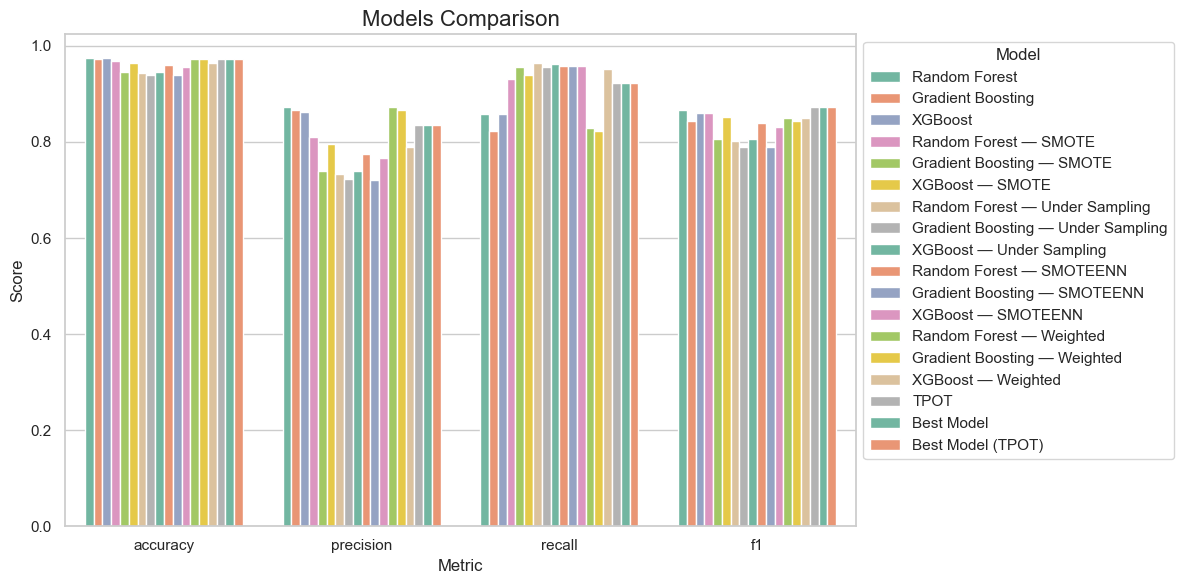

In [61]:
plot_comparison(hard_load('model_results.pkl'))

The evaluation shows that the AutoML model performs well, with a high F1-score and comparable performance to the previous models.
While `accuracy` and `recall` scores are similar to the previous models, and `precision` is actually generally not higher, the resulting `f1` score is a bit higher compared to all the previous models. This metrics is probably the most important one, as it provides a balanced measure of a model's precision and recall. This concludes that the found bast model from the autoML process is at least in line with the manually trained models, if not even slightly better.

# Step 7: Conclusion

This section resumes the comparison and performance of the models trained in the previous steps.

Additionally, the feature importance of the best tree-based model is analyzed.

## Best models

The best model for each metric, model type, and technique is identified. As main metric the `f1` score is used, as it provides a balanced measure of a model's precision and recall.

### Best model per metric

The best model for each metric is identified. The results show a general high quality among the (best) models, on all the metrics considered (f1, accuracy, precision, recall).

In [62]:
best_model_f1 = find_best('model_results.pkl', 'f1')
best_model_accuracy = find_best('model_results.pkl', 'accuracy')
best_model_precision = find_best('model_results.pkl', 'precision')
best_model_recall = find_best('model_results.pkl', 'recall')

best_model_per_metric = f"""
Best model per metric:
- F1 Score:     "{best_model_f1}" with F1 Score of {results[best_model_f1]['f1']:0.5f}
- Accuracy:     "{best_model_accuracy}" with Accuracy of {results[best_model_accuracy]['accuracy']:0.5f}
- Precision:    "{best_model_precision}" with Precision of {results[best_model_precision]['precision']:0.5f}
- Recall:       "{best_model_recall}" with Recall of {results[best_model_recall]['recall']:0.5f}
"""

print(best_model_per_metric)


Best model per metric:
- F1 Score:     "TPOT" with F1 Score of 0.87343
- Accuracy:     "Random Forest" with Accuracy of 0.97525
- Precision:    "Random Forest" with Precision of 0.87243
- Recall:       "Random Forest — Under Sampling" with Recall of 0.96381



### Best model per type

The best model for each type is identified based on the F1 score. The results show that the base version of each of the types of models is the best performing one (based on the f1 score), suggesting that the base models are already quite effective in capturing the patterns in the dataset and that the class imbalance techniques adapted do not  enough improvements to overtake the base versions of the models (again, considering the f1 score as the comparison metrics).

In [63]:
best_model_random_forest = find_best('model_results.pkl', 'f1', 'Random Forest')
best_model_gradient_boosting = find_best('model_results.pkl', 'f1', 'Gradient Boosting')
best_model_xgboost = find_best('model_results.pkl', 'f1', 'XGBoost')

best_model_per_type = f"""
Best model per type:
- Random Forest:        "{best_model_random_forest}" with F1 Score of {results[best_model_random_forest]['f1']:0.5f}
- Gradient Boosting:    "{best_model_gradient_boosting}" with F1 Score of {results[best_model_gradient_boosting]['f1']:0.5f}
- XGBoost:              "{best_model_xgboost}" with F1 Score of {results[best_model_xgboost]['f1']:0.5f}
"""

print(best_model_per_type)


Best model per type:
- Random Forest:        "Random Forest" with F1 Score of 0.86560
- Gradient Boosting:    "Gradient Boosting" with F1 Score of 0.84297
- XGBoost:              "XGBoost" with F1 Score of 0.85999



### Best model per technique

The best model for each technique is identified based on the F1 score. This highlights the most effective approach for handling the class imbalance in the dataset, for each of the type of models considered.

In [64]:
best_model_smote = find_best('model_results.pkl', 'f1', 'SMOTE')
best_model_under = find_best('model_results.pkl', 'f1', 'Under Sampling')
best_model_smoteenn = find_best('model_results.pkl', 'f1', 'SMOTEENN')
best_model_weighted = find_best('model_results.pkl', 'f1', 'Weighted')

best_model_per_technique = f"""
Best model per technique:
- SMOTE:            "{best_model_smote}" with F1 Score of {results[best_model_smote]['f1']:0.5f}
- Under Sampling:   "{best_model_under}" with F1 Score of {results[best_model_under]['f1']:0.5f}
- SMOTEENN:         "{best_model_smoteenn}" with F1 Score of {results[best_model_smoteenn]['f1']:0.5f}
- Weighted:         "{best_model_weighted}" with F1 Score of {results[best_model_weighted]['f1']:0.5f}
"""

print(best_model_per_technique)


Best model per technique:
- SMOTE:            "Random Forest — SMOTE" with F1 Score of 0.85966
- Under Sampling:   "XGBoost — Under Sampling" with F1 Score of 0.80673
- SMOTEENN:         "Random Forest — SMOTEENN" with F1 Score of 0.83882
- Weighted:         "Random Forest — Weighted" with F1 Score of 0.84941



### Best model overall

The best model overall is identified based on the F1 score. This results to be the one obtained from the AutoML process. Its performance metrics is reported below.


Best model overall: "TPOT" with F1 Score of 0.87343



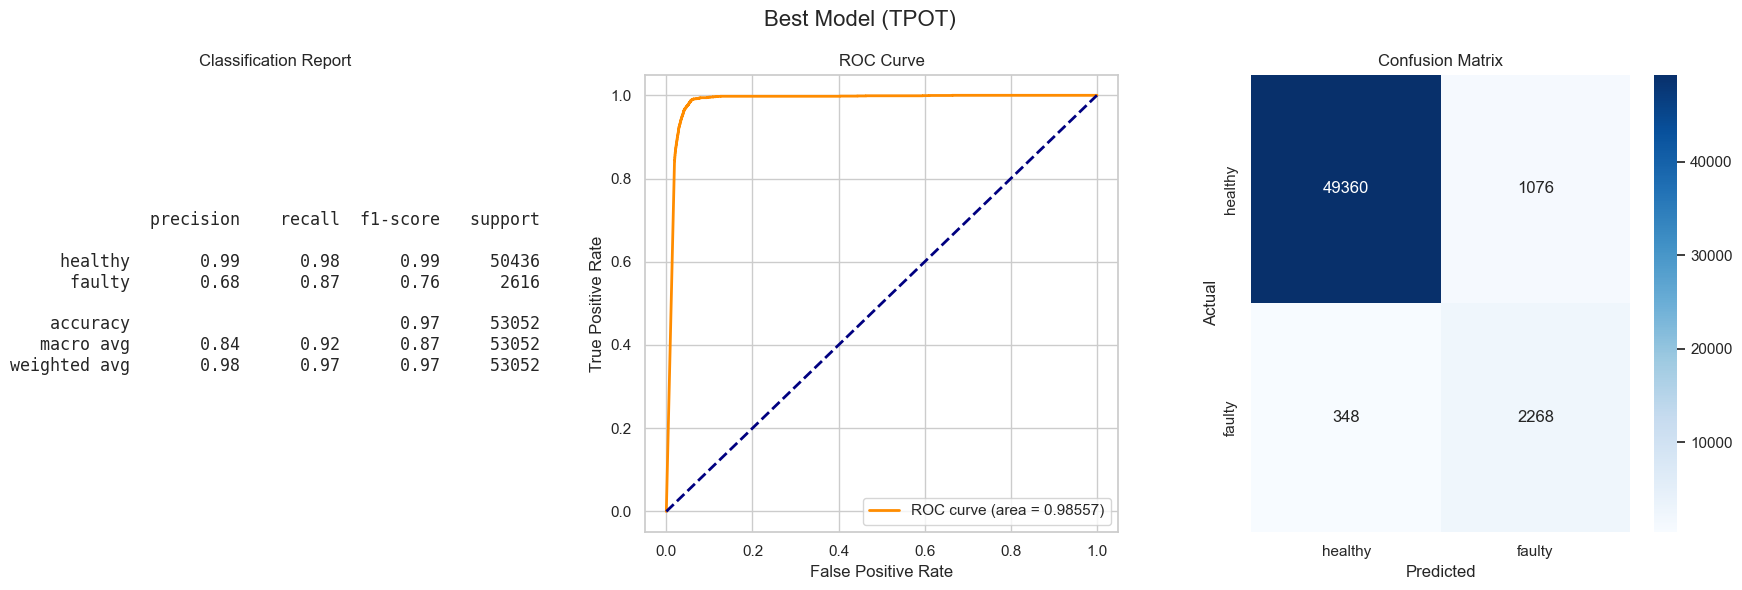

In [65]:
best_model = find_best('model_results.pkl', 'f1')

best_model_overall = f"""
Best model overall: "{best_model}" with F1 Score of {results[best_model]['f1']:0.5f}
"""

print(best_model_overall)

_ = run_model(results[best_model]['model'], X_train, y_train, X_test, y_test, save_to='model_results.pkl', model_name=f'Best Model ({best_model})')

## Feature Importance

The feature importance of the best version of the Random Forest model (which is the best performing model among the tree-based one) is analyzed to understand which features have the most significant impact on the model's predictions.

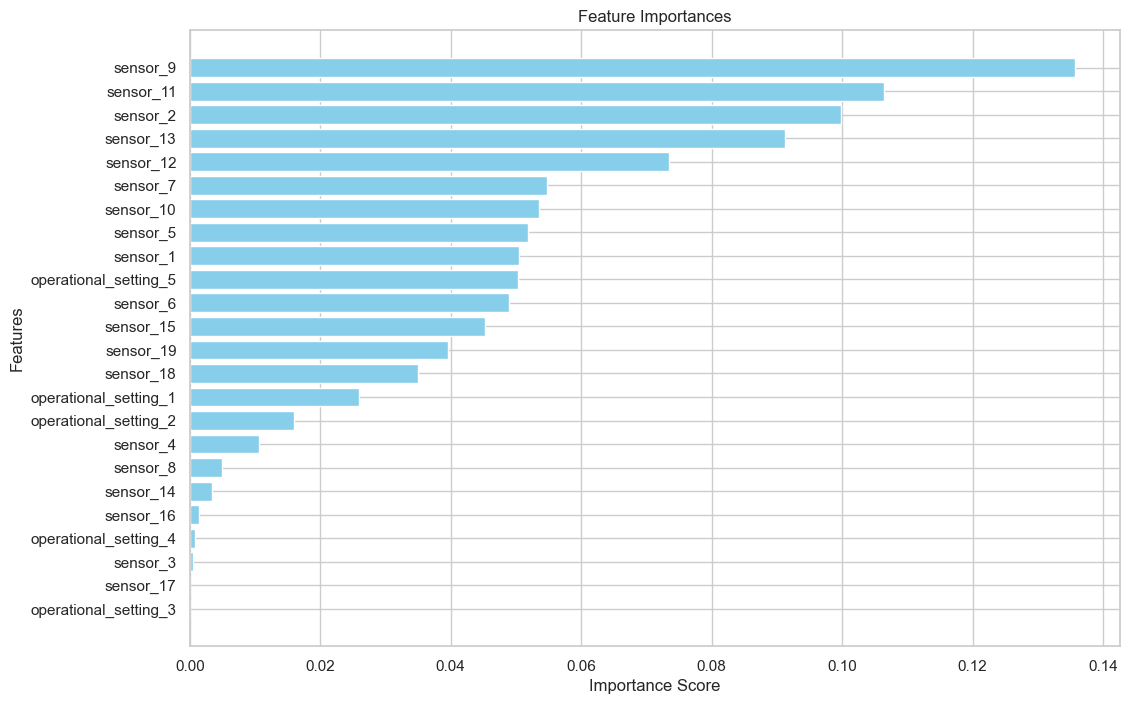

In [66]:
feature_importance = results[best_model_random_forest]['model'].feature_importances_
feature_names = [feat for feat in features_in_use if not feat.endswith('_avg')]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


The most important features are `sensor_9`, `sensor_11`, `sensor_2`, `sensor_13`, and `sensor_12`. These sensors show a strong influence on the model’s predictive performance, indicating their critical role in capturing engine behavior and early indicators of failure.

Features like `sensor_7`, `sensor_10`, `sensor_5`, and `sensor_1` exhibit moderate importance. While not as critical as the top features, these sensors still capture meaningful information.

Finally, `operational_setting_5` is the only operational feature with moderate importance, indicating that it captures some influence on engine failure.